## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, log_loss, auc
from matplotlib import pyplot as plt
import copy

sys.path.insert(0, "../")
from eval_metrics import lift_at_k
from active_learning_scores import least_confidence
from experimental_scores import probability_mass_above_given_label_score

# experimental version of label quality ensemble scores with additional weighting schemes
from label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Models

In [2]:
models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224",
]

### Dictionaries to map to display names

In [3]:
# dictionaries to map to display name

method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",

}

model_display_name_dict = {
    "swin_base_patch4_window7_224": "Swin Transformer",
    "twins_pcpvt_base": "Twins PCPVT",
    "efficientnet_b1": "EfficientNet-B1",
    "resnet50d": "ResNet-50d",
    "resnet18": "ResNet-18",
}

## Load Data 
#### Load Roman Numeral files from experiments

In [54]:
ANNOTATION_PATH = "./andrew-ng-dcai-comp-2021-manual-review-for-label-errors.xlsx"
df = pd.read_excel(ANNOTATION_PATH, index_col=0)
# df = connect_label_errors(annotation_path=ANNOTATION_PATH, train_val_dataset=train_val_dataset)
label_error_map = {'Keep Data': 0, 'Fix Data Label': 1, 'Remove Bad Data': 2}
roman_numeral_map = {'i': 1, 'ii': 2, 'iii': 3, 'iv': 4, 'ix':9, 'v':5, 'vi':6, 'vii':7, 'viii':8, 'x':10}
df['action'] = np.array(df['action'].map(label_error_map))
df['given_label'] = np.array(df['given_label'].map(roman_numeral_map))
df['corrected_label'] = np.array(df['corrected_label'].map(roman_numeral_map))
df.head()

,label_error,action,given_label,corrected_label,file_path,image_public_url
image,,,,,,
NaN,True,1,1,2.0,train/i/abf15a58-ce5d-11eb-b317-38f9d35ea60f.png,https://worksheets.codalab.org/rest/bundles/0x497f5d7096724783aa1eb78b85aa321f/contents/blob/andrew-ng-dcai-comp-2021-data/train/i/abf15a58-ce5d-11eb-b317-38f9d35ea60f.png
NaN,True,1,1,10.0,train/i/ac14e8ba-ce5d-11eb-b317-38f9d35ea60f.png,https://worksheets.codalab.org/rest/bundles/0x497f5d7096724783aa1eb78b85aa321f/contents/blob/andrew-ng-dcai-comp-2021-data/train/i/ac14e8ba-ce5d-11eb-b317-38f9d35ea60f.png
NaN,True,1,1,3.0,train/i/ac156ed4-ce5d-11eb-b317-38f9d35ea60f.png,https://worksheets.codalab.org/rest/bundles/0x497f5d7096724783aa1eb78b85aa321f/contents/blob/andrew-ng-dcai-comp-2021-data/train/i/ac156ed4-ce5d-11eb-b317-38f9d35ea60f.png
NaN,True,1,1,5.0,train/i/ac268e44-ce5d-11eb-b317-38f9d35ea60f.png,https://worksheets.codalab.org/rest/bundles/0x497f5d7096724783aa1eb78b85aa321f/contents/blob/andrew-ng-dcai-comp-2021-data/train/i/ac268e44-ce5d-11eb-b317-38f9d35ea60f.png
NaN,True,1,1,2.0,train/i/abf7a8e0-ce5d-11eb-b317-38f9d35ea60f.png,https://worksheets.codalab.org/rest/bundles/0x497f5d7096724783aa1eb78b85aa321f/contents/blob/andrew-ng-dcai-comp-2021-data/train/i/abf7a8e0-ce5d-11eb-b317-38f9d35ea60f.png


In [57]:
np.sum(df[df['action'] == 0]['label_error']) 

1

In [61]:
len(df[df['action'] == 0])

2508

#### Load Pred Probs data from experiment

In [63]:
experiments = []

for xval in ["-xval"]:
    for model in models:
        print(model, xval)

        #### Andrew Ng DCAI Roman Numerals ####

        # read numpy files
        numpy_out_folder = f"./roman-numeral{xval}/roman-numeral_train_val_dataset_cv_{model}/"
        pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
        labels = np.load(numpy_out_folder + "noisy_labels.npy")
        images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
        label_errors_mask = np.load(numpy_out_folder + "label_errors_mask.npy")
        
        # read excel files
        file_path = df['file_path'].to_numpy()
        actions = df['action'].to_numpy()
        given_label = df['given_label'].to_numpy()
        corrected_label = df['corrected_label'].to_numpy()
        
        # find re-index correctly
        image_path = ['/'.join(Path(x).parts[-3:]) for x in images]
        file_path_dict = dict(zip(file_path, range(len(df))))
        image_idxs = np.array([file_path_dict[path] for path in image_path])
        print(len(image_path), len(file_path_dict), len(image_idxs))
        
        # re-index excel files
        file_path = file_path[image_idxs]
        actions = actions[image_idxs]
        given_label = given_label[image_idxs]
        corrected_label = corrected_label[image_idxs]
        
        # test indexing
        print(all(file_path == image_path))

        # store results of experiment
        experiment_results = {
            "dataset": "roman-numeral",
            "model": model,
            "pred_probs": pred_probs,
            "labels": labels,
            "images": images,
            "label_errors_mask": label_errors_mask,
            "type_train": xval,
            "action" : actions,
            "given_label" : given_label,
            "corrected_label": corrected_label,
        }
        
        experiments.append(experiment_results)

resnet18 -xval
2831 2880 2831
True
resnet50d -xval
2831 2880 2831
True
efficientnet_b1 -xval
2831 2880 2831
True
twins_pcpvt_base -xval
2831 2880 2831
True
swin_base_patch4_window7_224 -xval
2831 2880 2831
True


In [64]:
def keep_only_errors(experiment,label_errors_mask):
    experiment = experiment.copy()
    label_errors_mask = experiment["label_errors_mask"]
    num_errors = np.sum(experiment["label_errors_mask"])
    experiment["pred_probs"] = experiment["pred_probs"][label_errors_mask]
    experiment["labels"] = experiment["labels"][label_errors_mask]
    experiment["images"] = experiment["images"][label_errors_mask]
    experiment["label_errors_mask"] = experiment["label_errors_mask"][label_errors_mask]
    experiment["action"] = np.array(experiment['action'])[label_errors_mask]
    experiment["given_label"] = np.array(experiment["given_label"])[label_errors_mask]
    experiment["corrected_label"] = np.array(experiment["corrected_label"])[label_errors_mask]
    print(f'{num_errors} == {len(experiment["labels"])}')
    return experiment

## Compute Values for Scatterplots

In [65]:
from cleanlab.internal.label_quality_utils import get_normalized_entropy

In [113]:
results = []

for experiment in experiments:
    # if we only want to look at errors
    experiment = keep_only_errors(experiment,label_errors_mask)
        
    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]
    type_train = experiment["type_train"]
    action = experiment["action"]

    # self confidence
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=False)

    # max pred_prob
    nm = get_label_quality_scores(labels, pred_probs, method='normalized_margin', adjust_pred_probs=False)
    max_prob_not_label = -1 * ((nm * 2) - 1 - self_confidence)
    
#     mask = pred_probs.copy()
#     mask[np.arange(mask.shape[0]), labels] = -1
#     pred_probs_prime = mask[mask != -1]
    
#     pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
# #     pred_probs_prime_norm = pred_probs_prime / np.sum(pred_probs_prime, axis=1)[:,np.newaxis]
#     max_pred_prob = np.amax(pred_probs_prime_norm, axis=1) # todo should I renormalize this
#     given_label = given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
#     given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
    
#     NM = given_label_prob - max_pred_prob
    
    # overall entropy
    normalized_entropy = get_normalized_entropy(pred_probs)
    results.append((f'H(p) vs self_confidence-{dataset}-{model}-{type_train}', normalized_entropy, self_confidence, action))
    results.append((f'M vs self_confidence-{dataset}-{model}-{type_train}', max_prob_not_label, self_confidence, action))
    results.append((f'NM vs self_confidence-{dataset}-{model}-{type_train}', nm, self_confidence, action))

    results.append((f'M vs H(p)-{dataset}-{model}-{type_train}', max_prob_not_label, normalized_entropy, action))
    results.append((f'NM vs H(p)-{dataset}-{model}-{type_train}', nm, normalized_entropy, action))

    

372 == 372
372 == 372
372 == 372
372 == 372
372 == 372


#### Plot Scatterplots

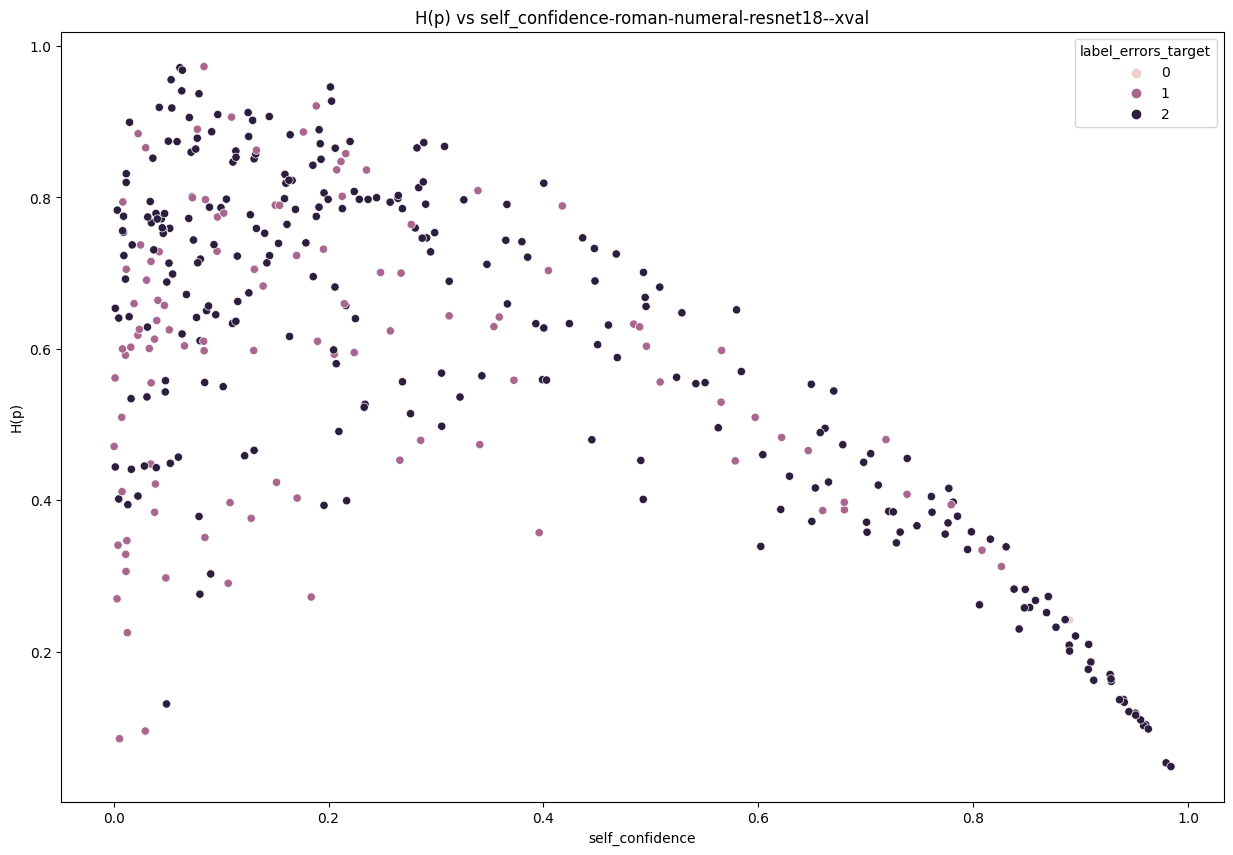

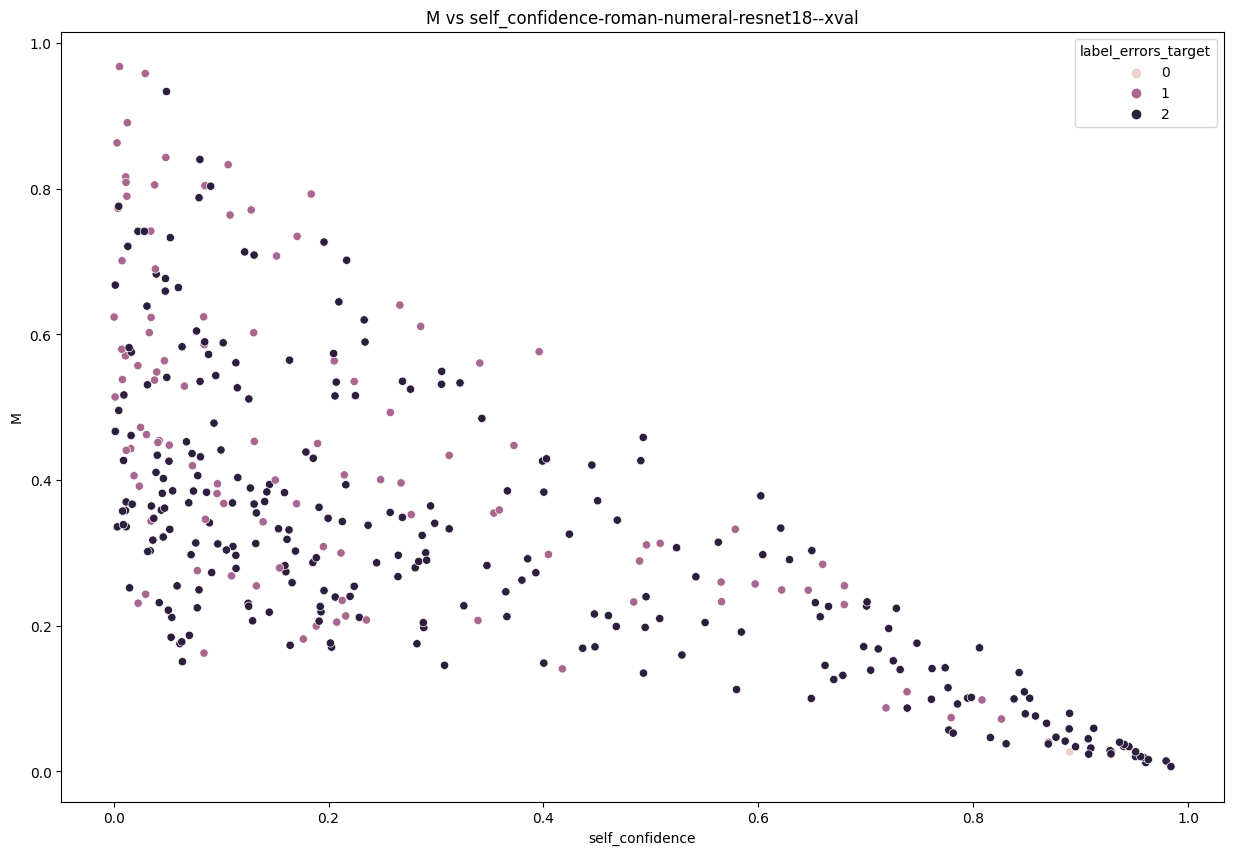

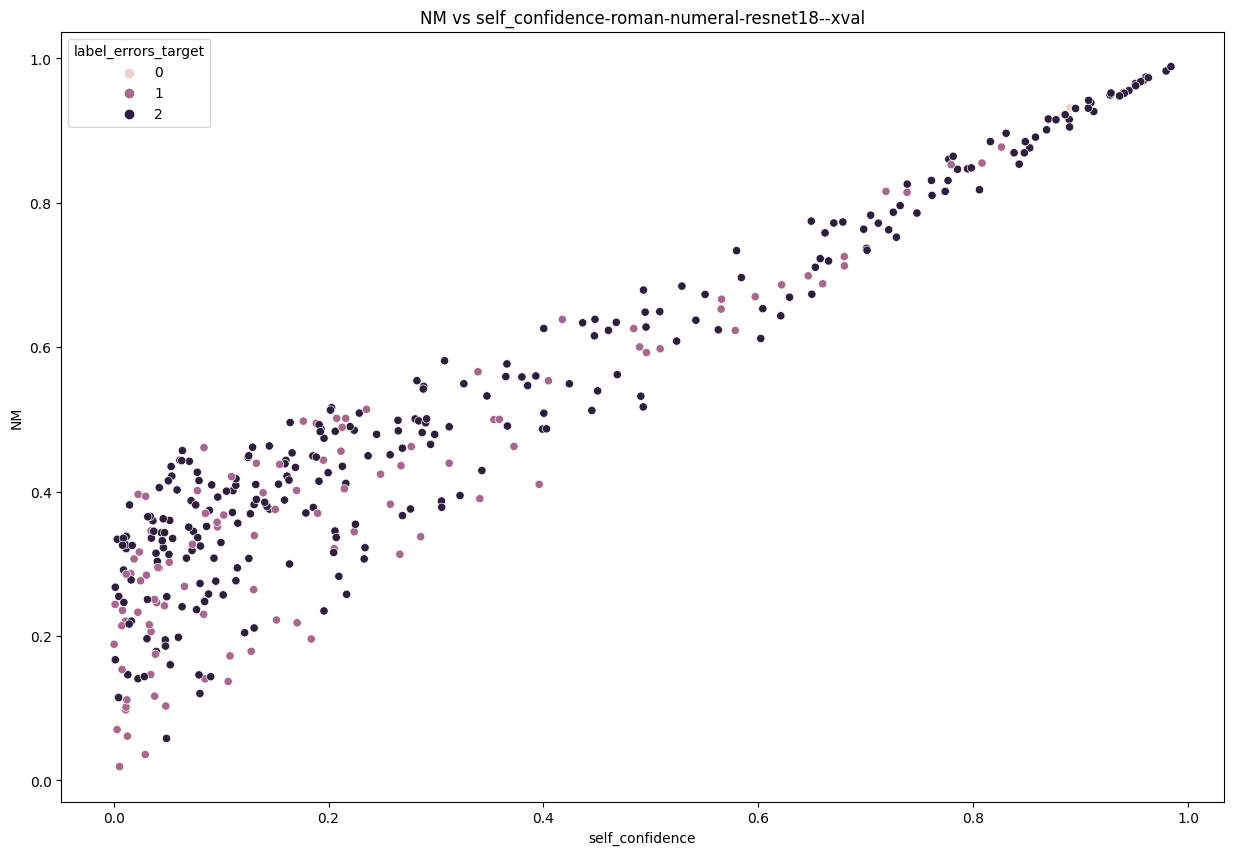

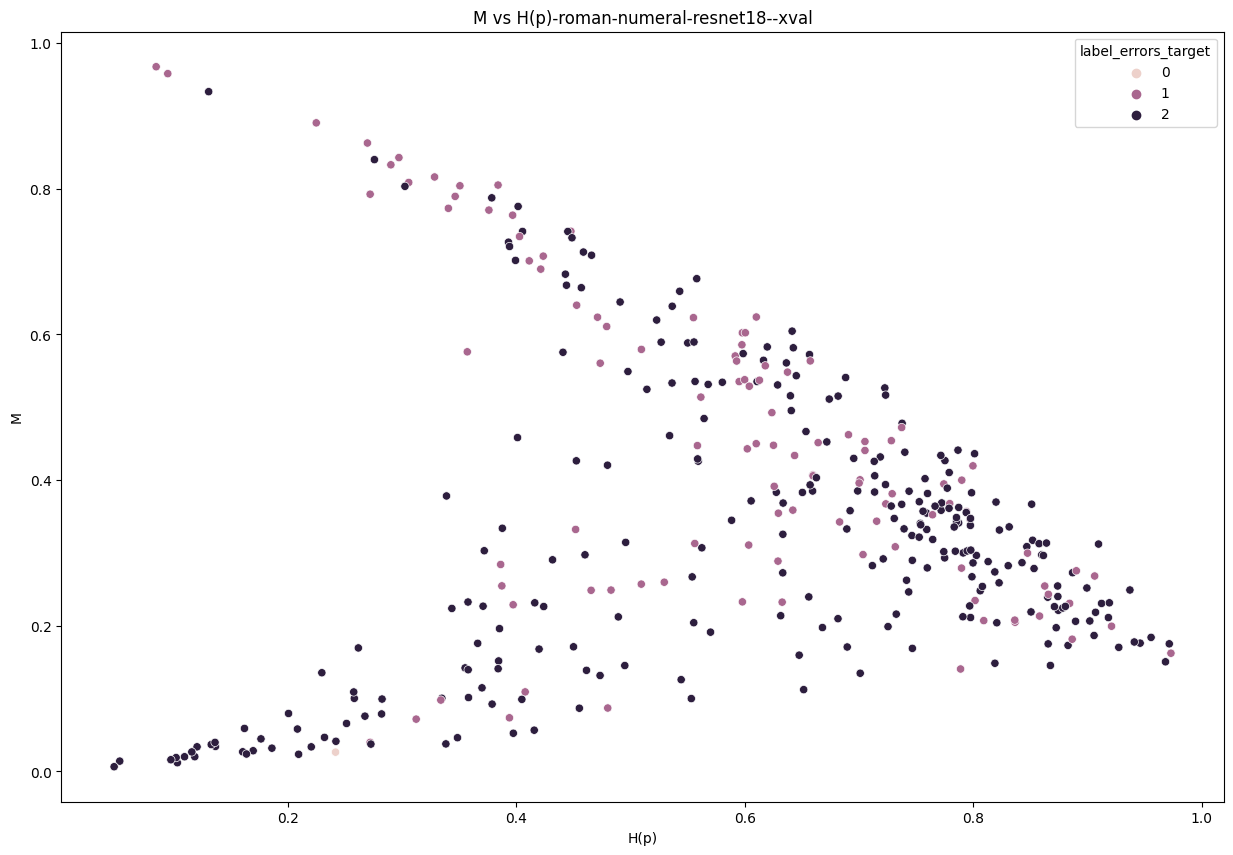

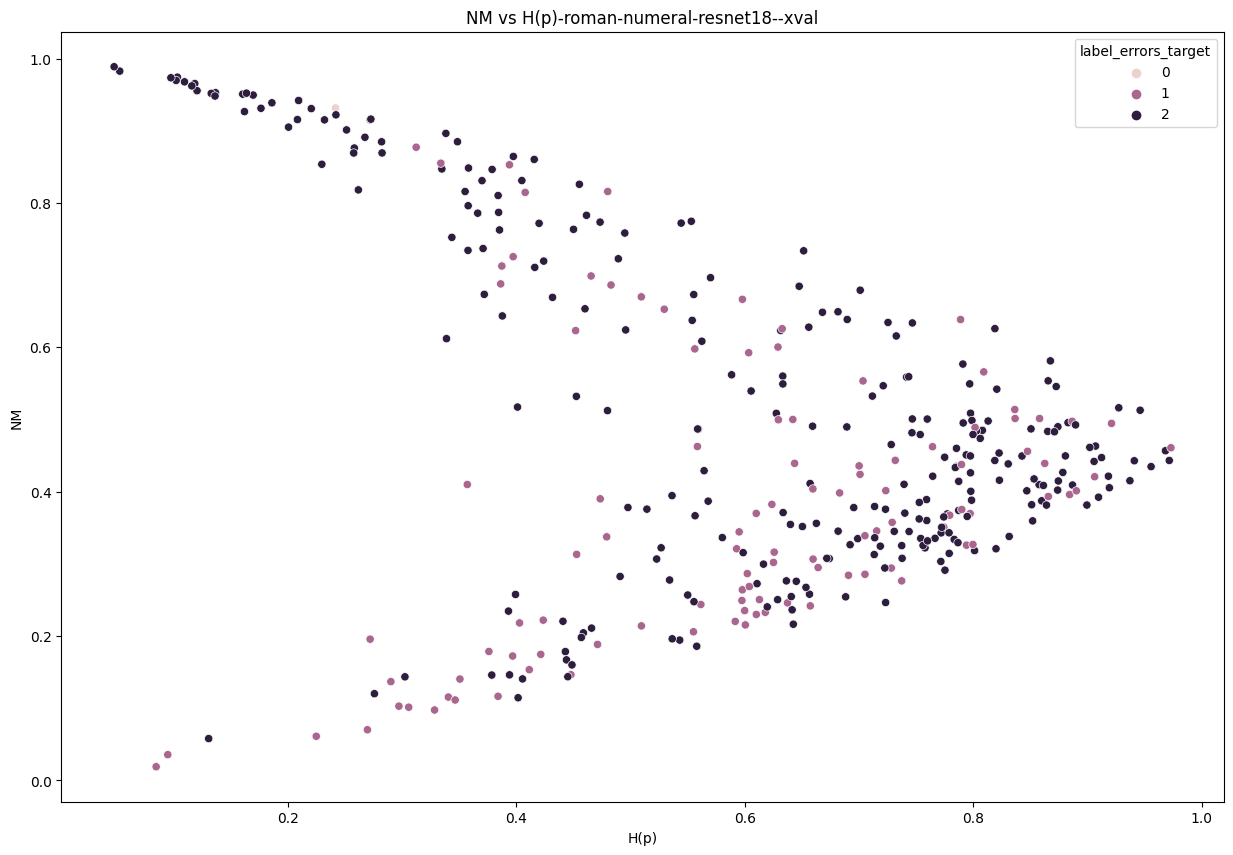

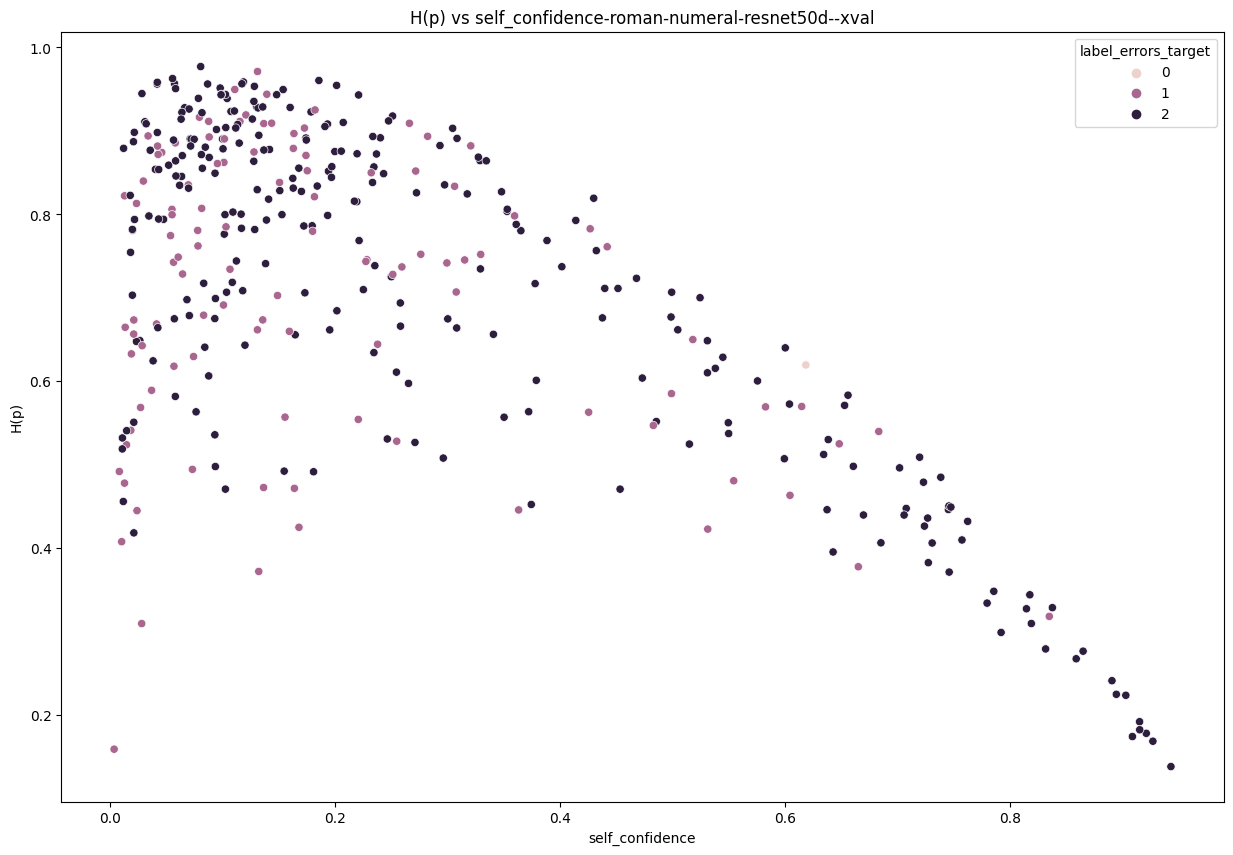

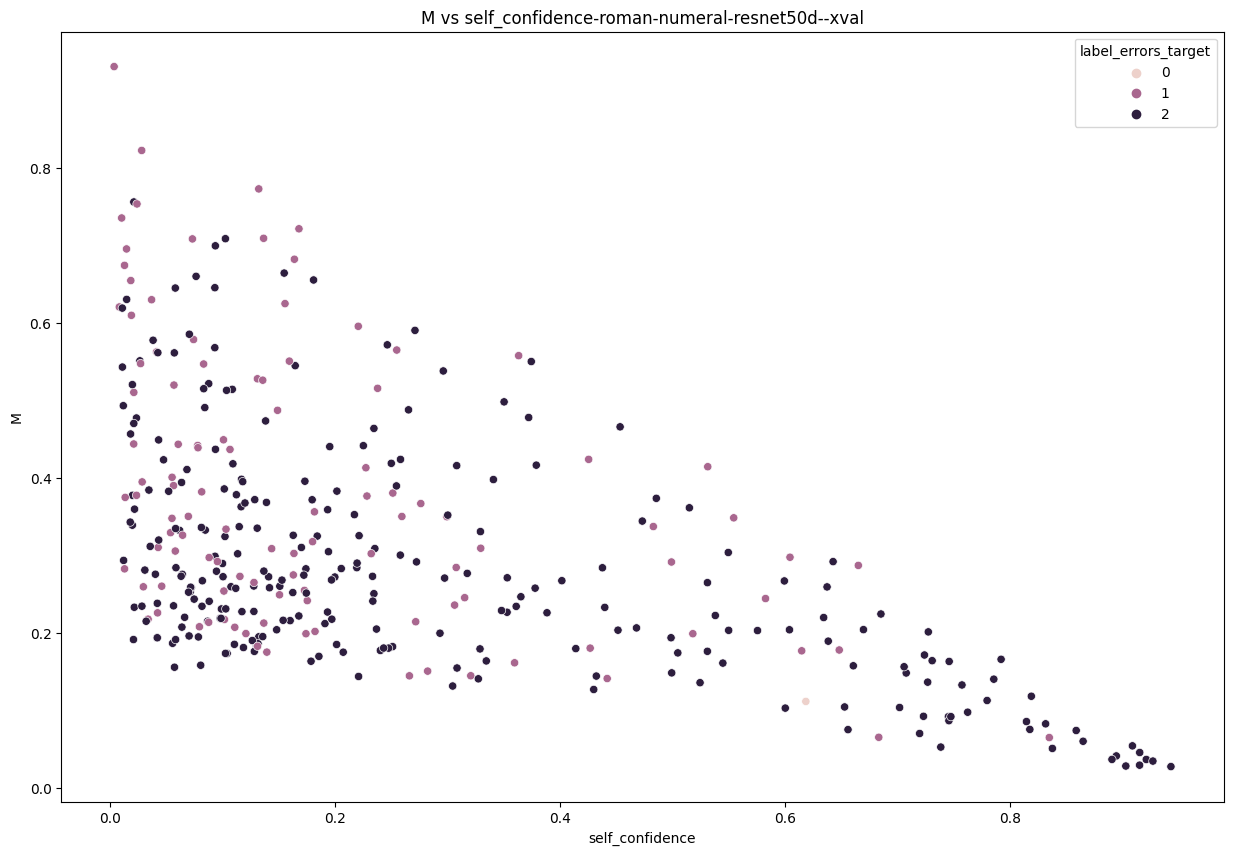

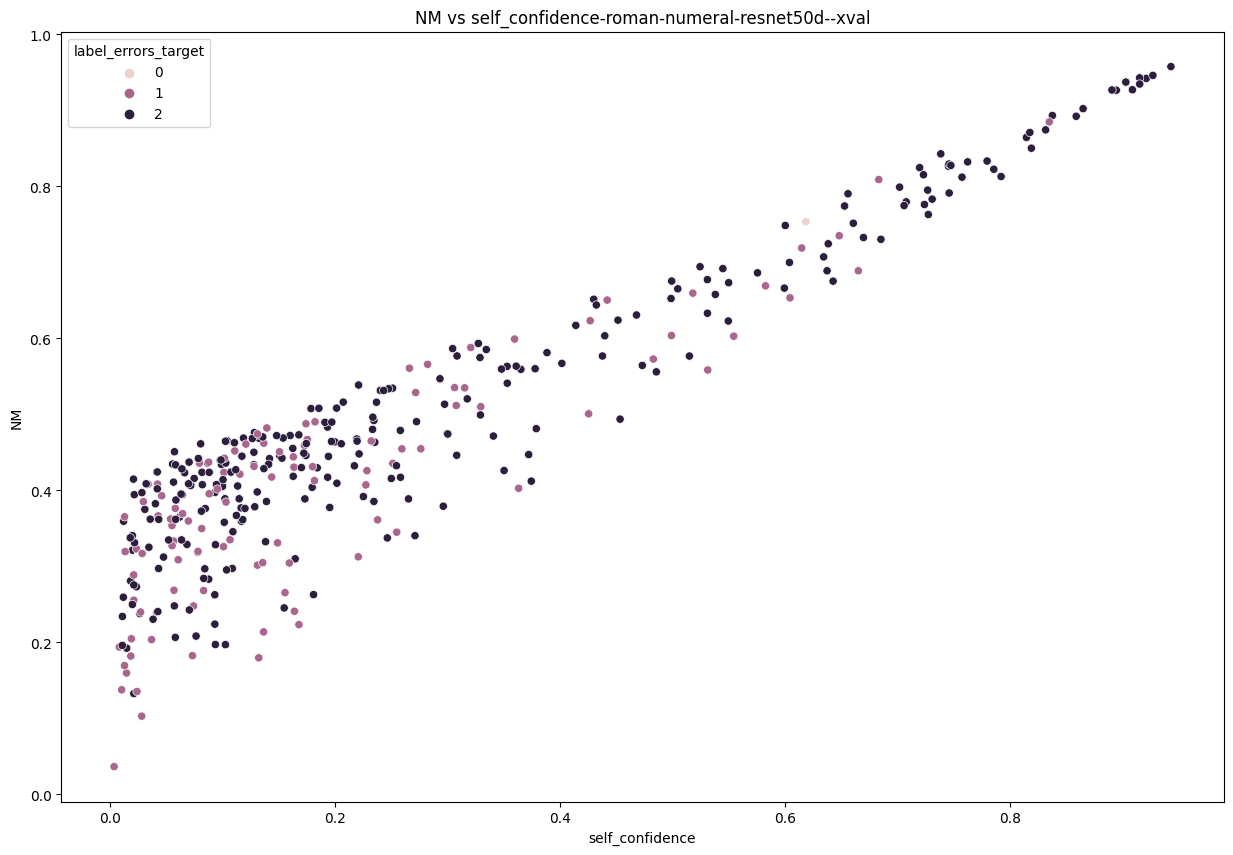

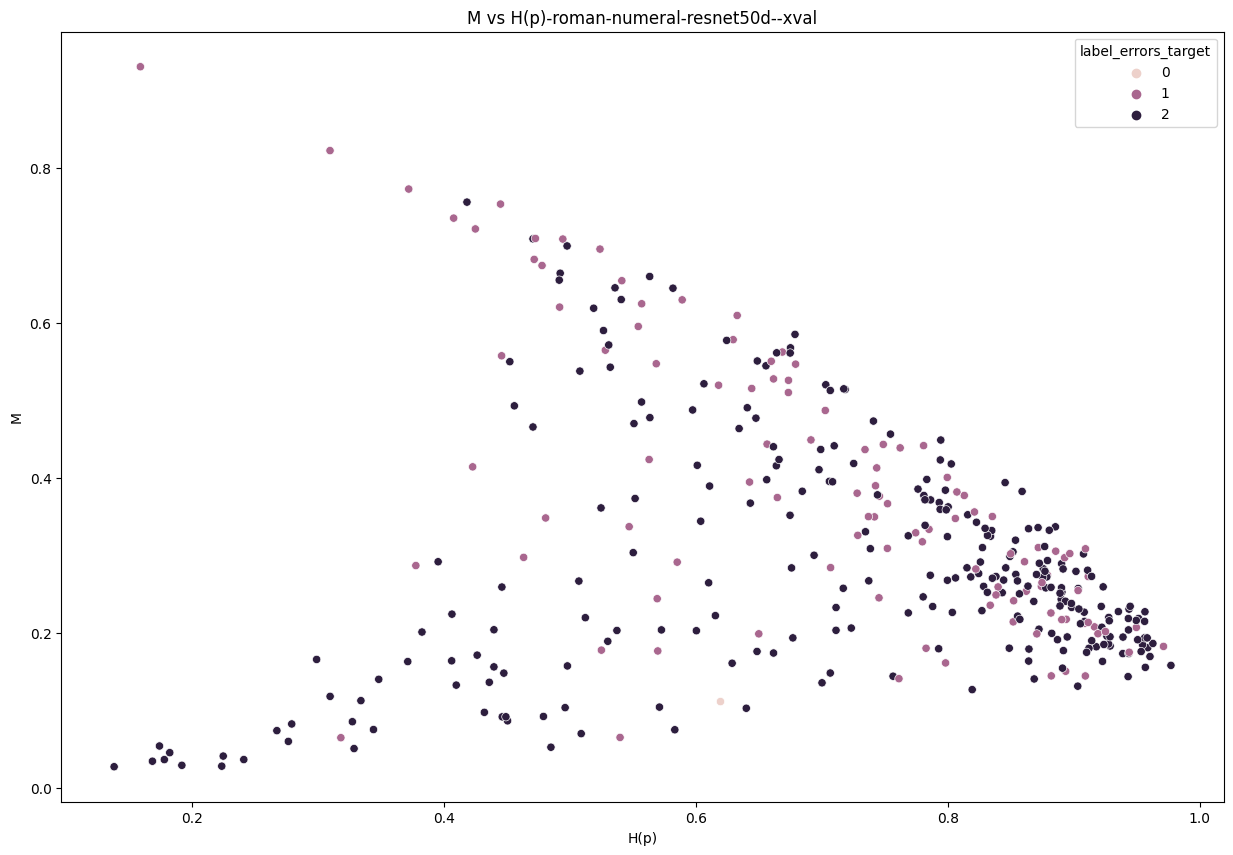

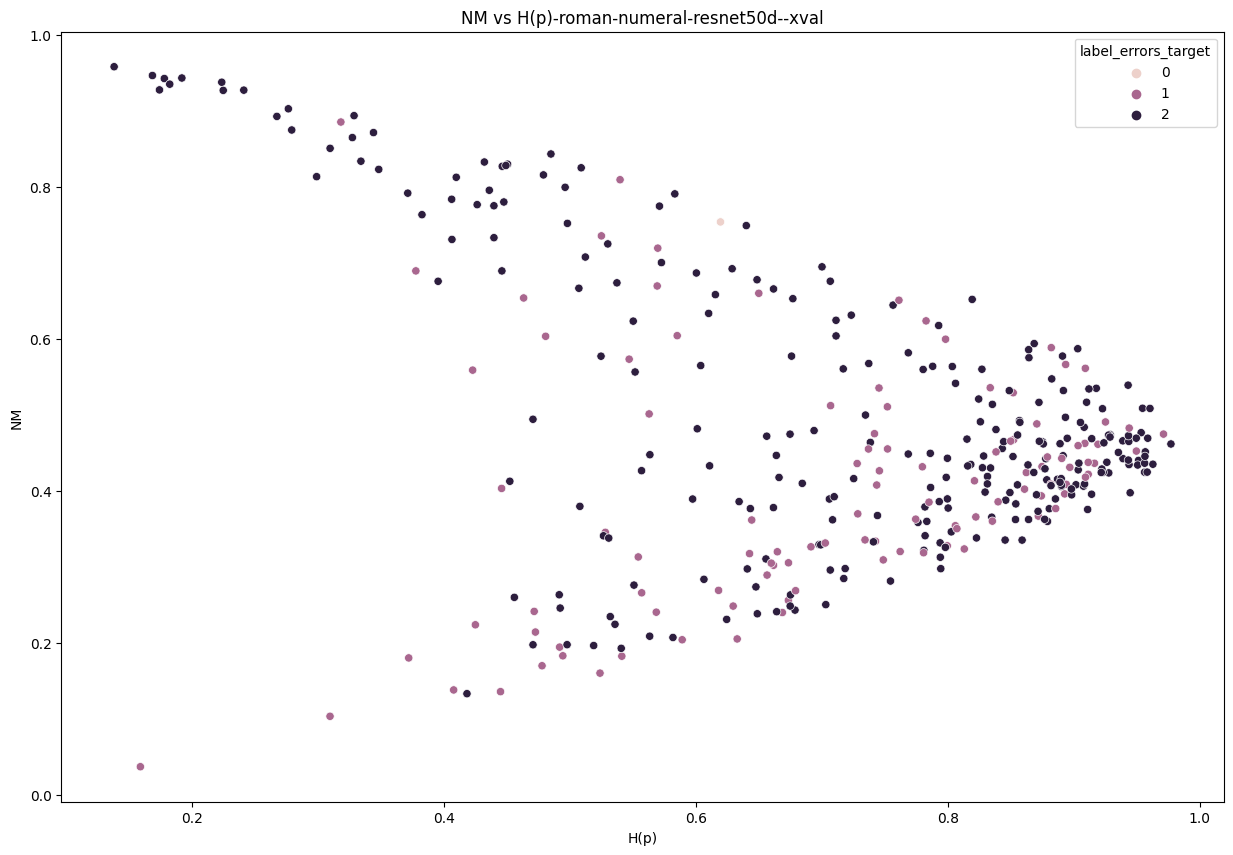

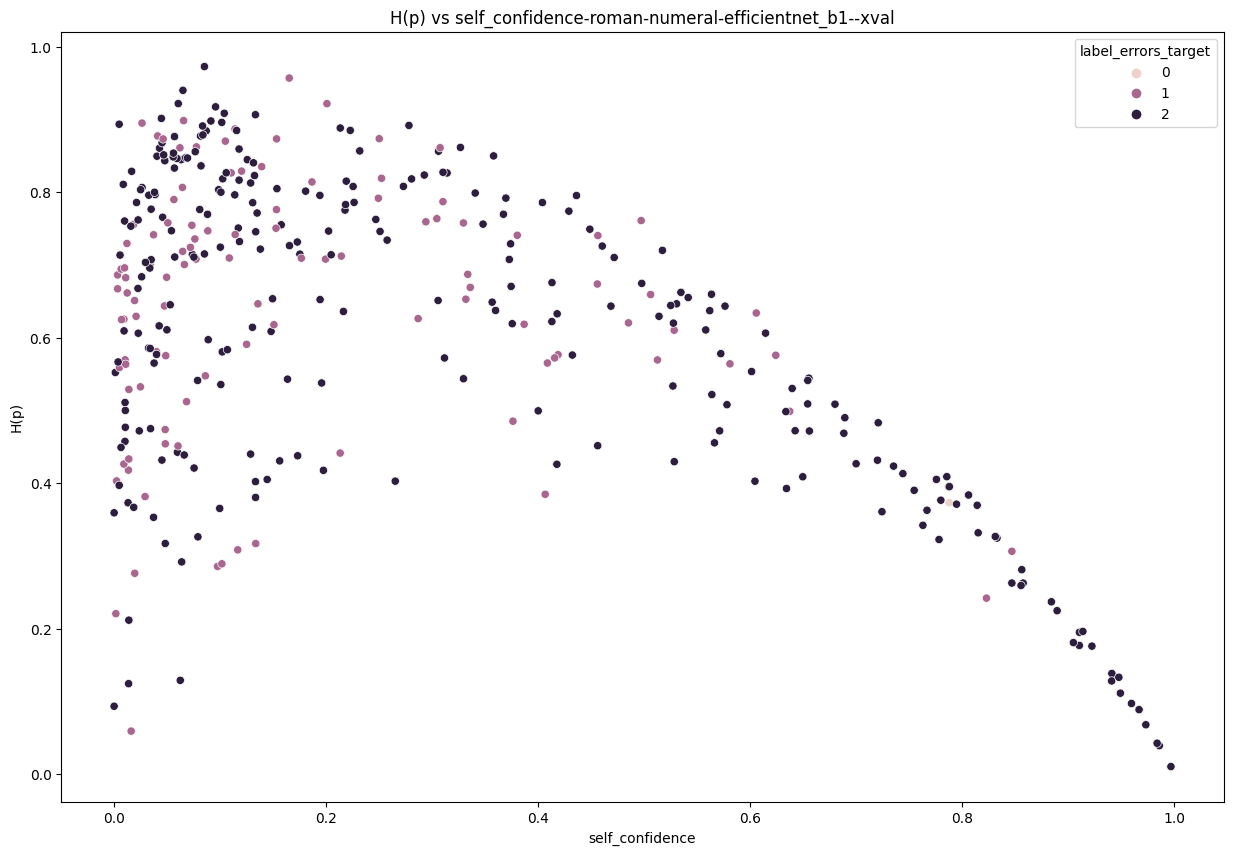

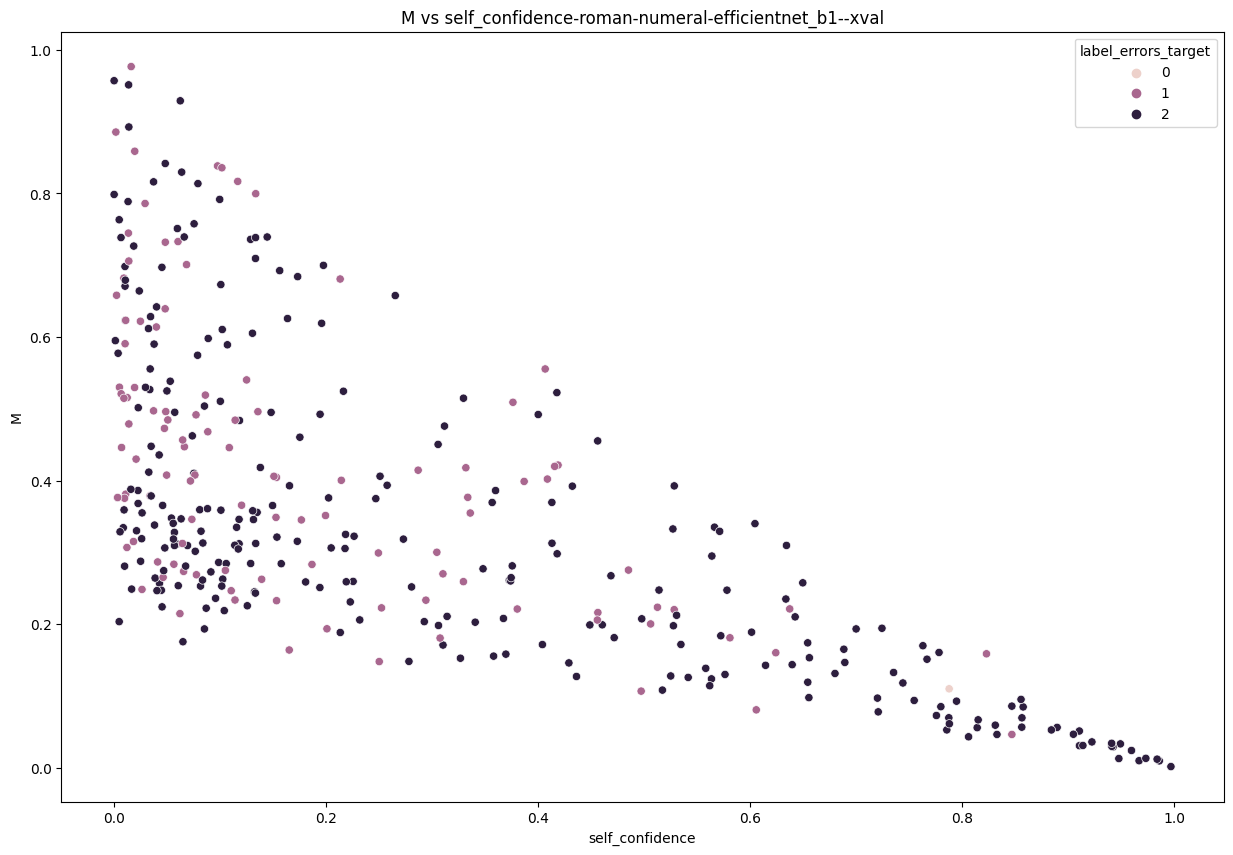

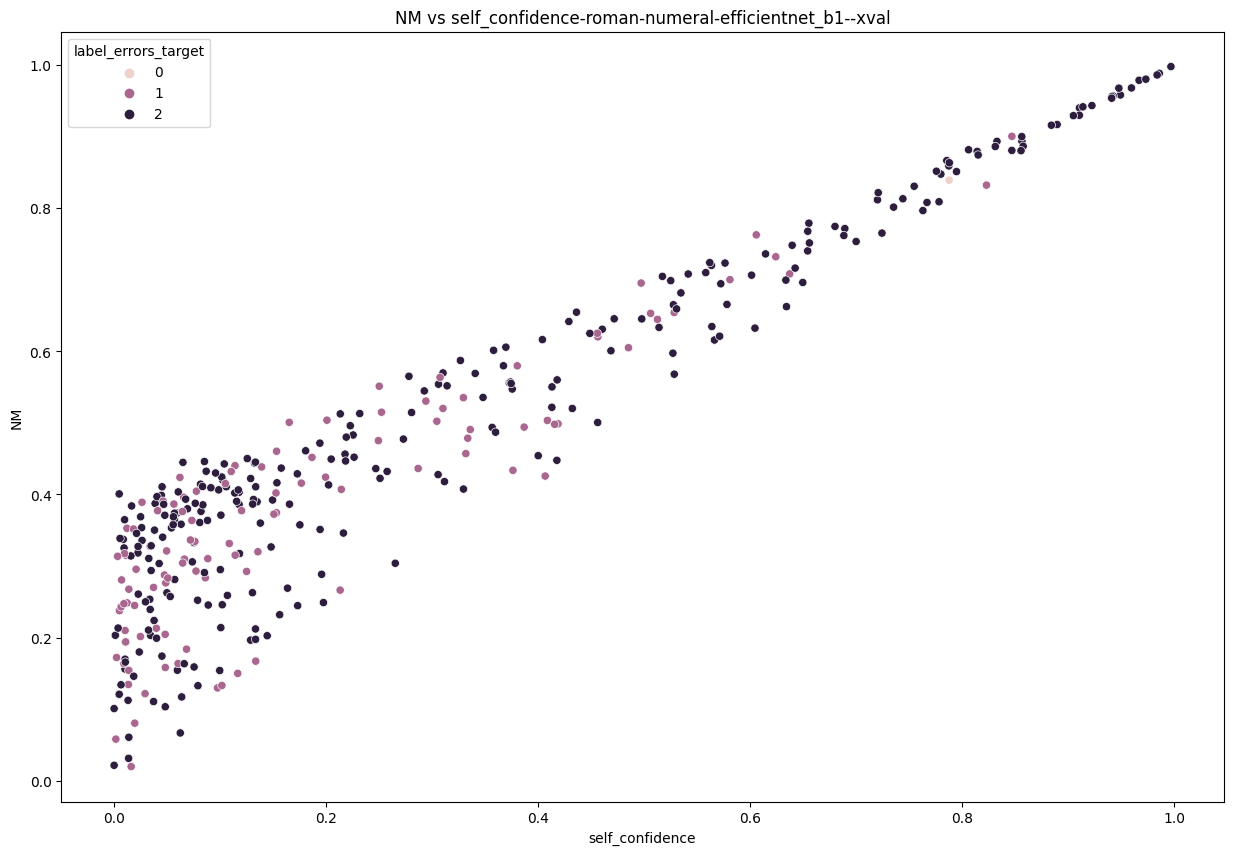

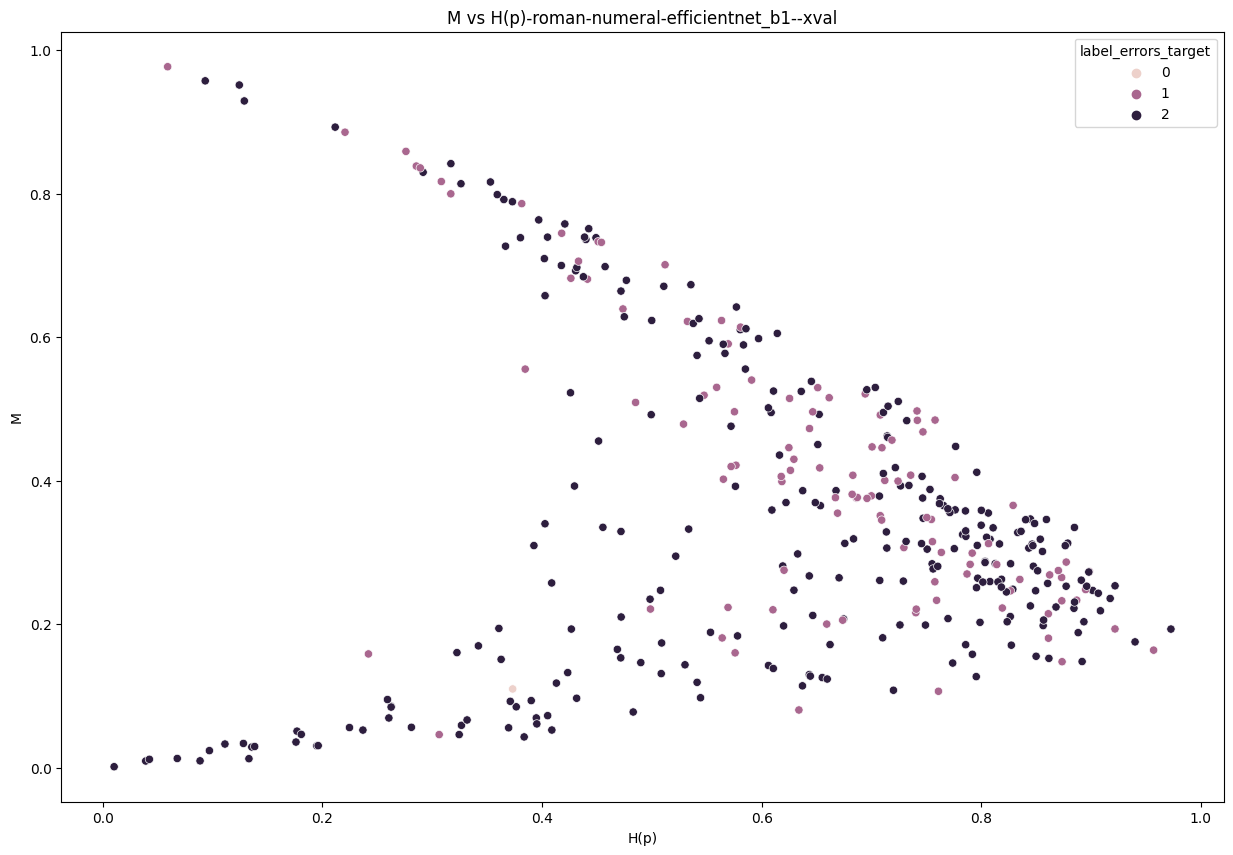

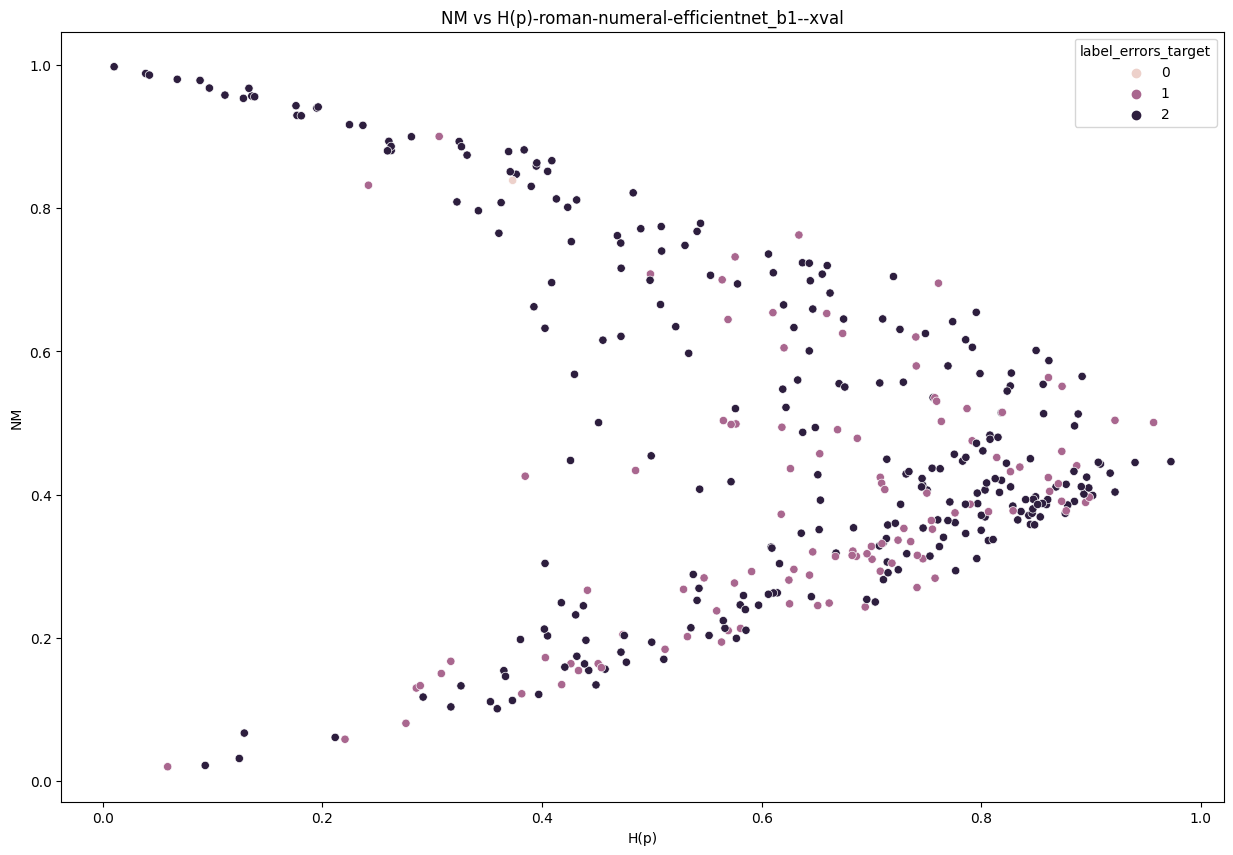

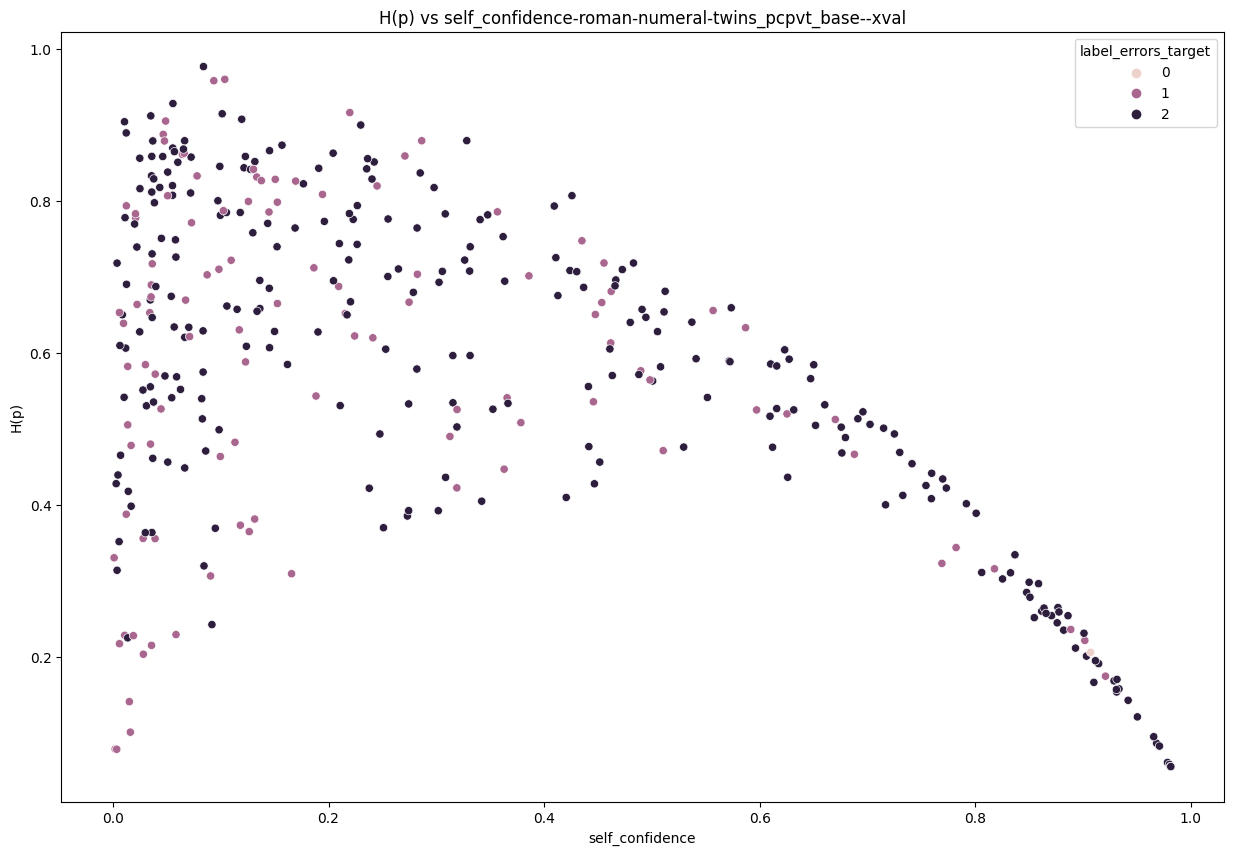

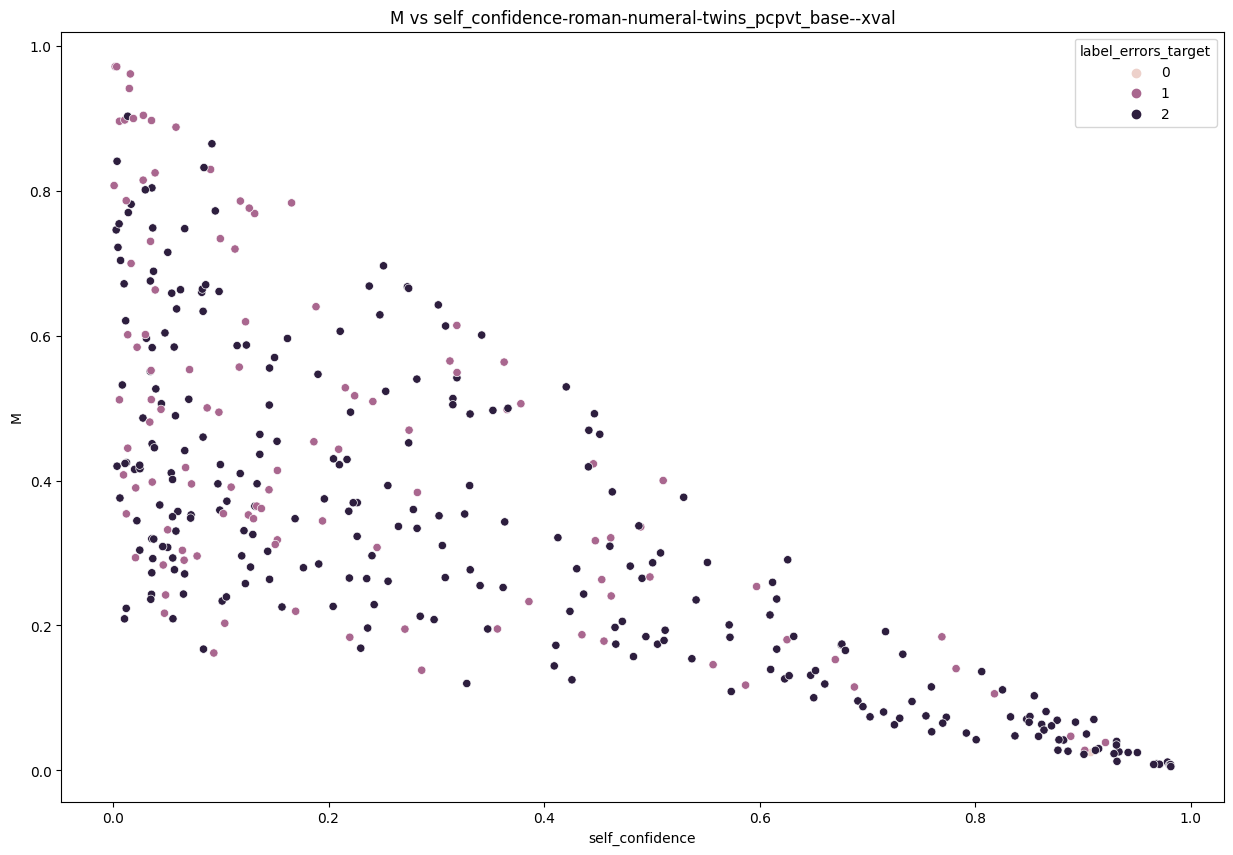

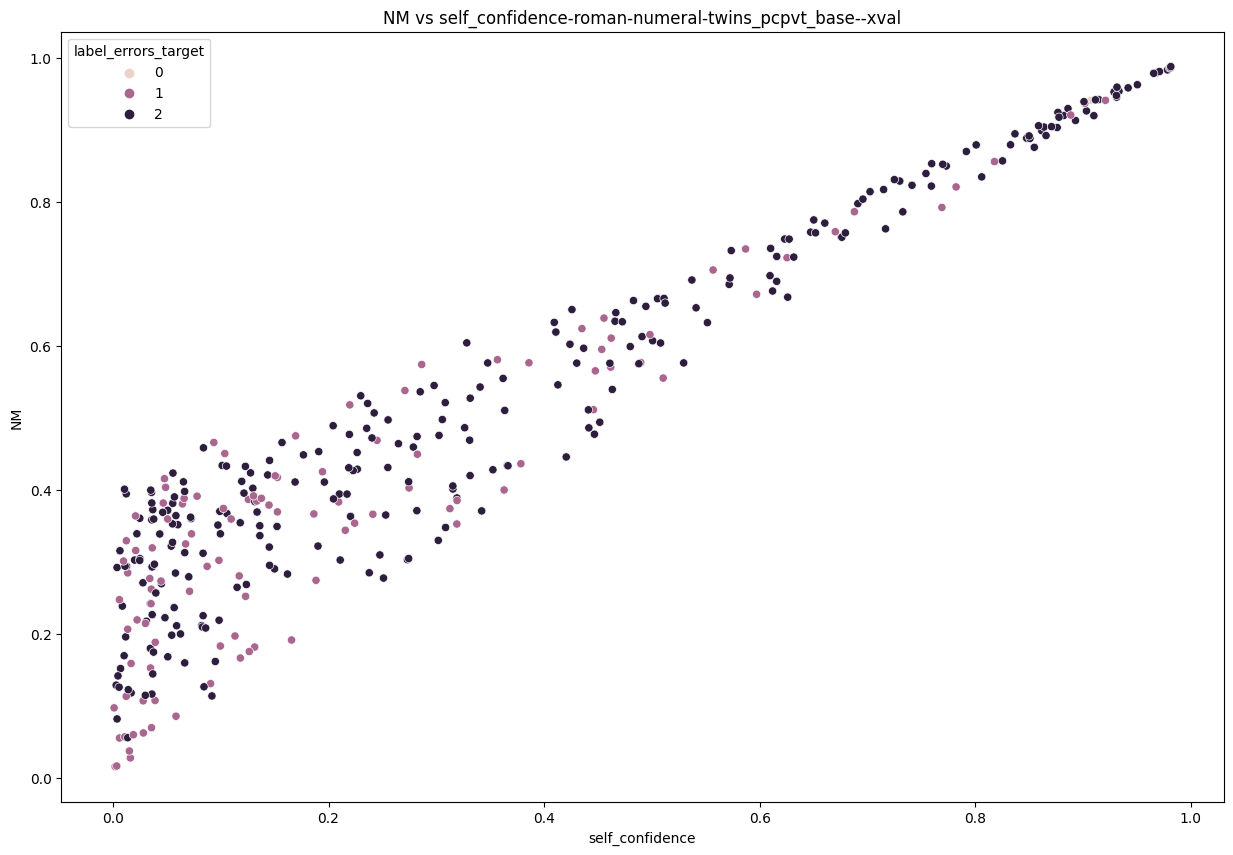

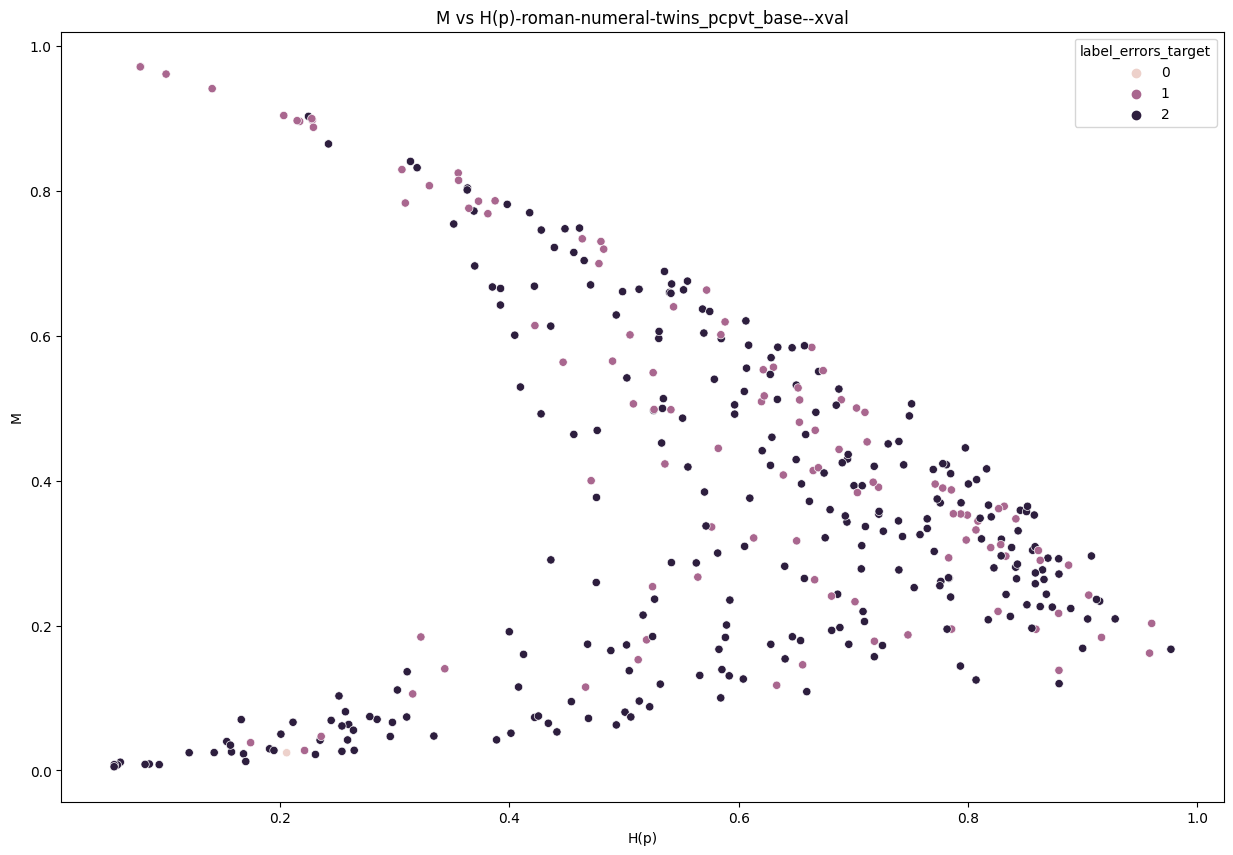

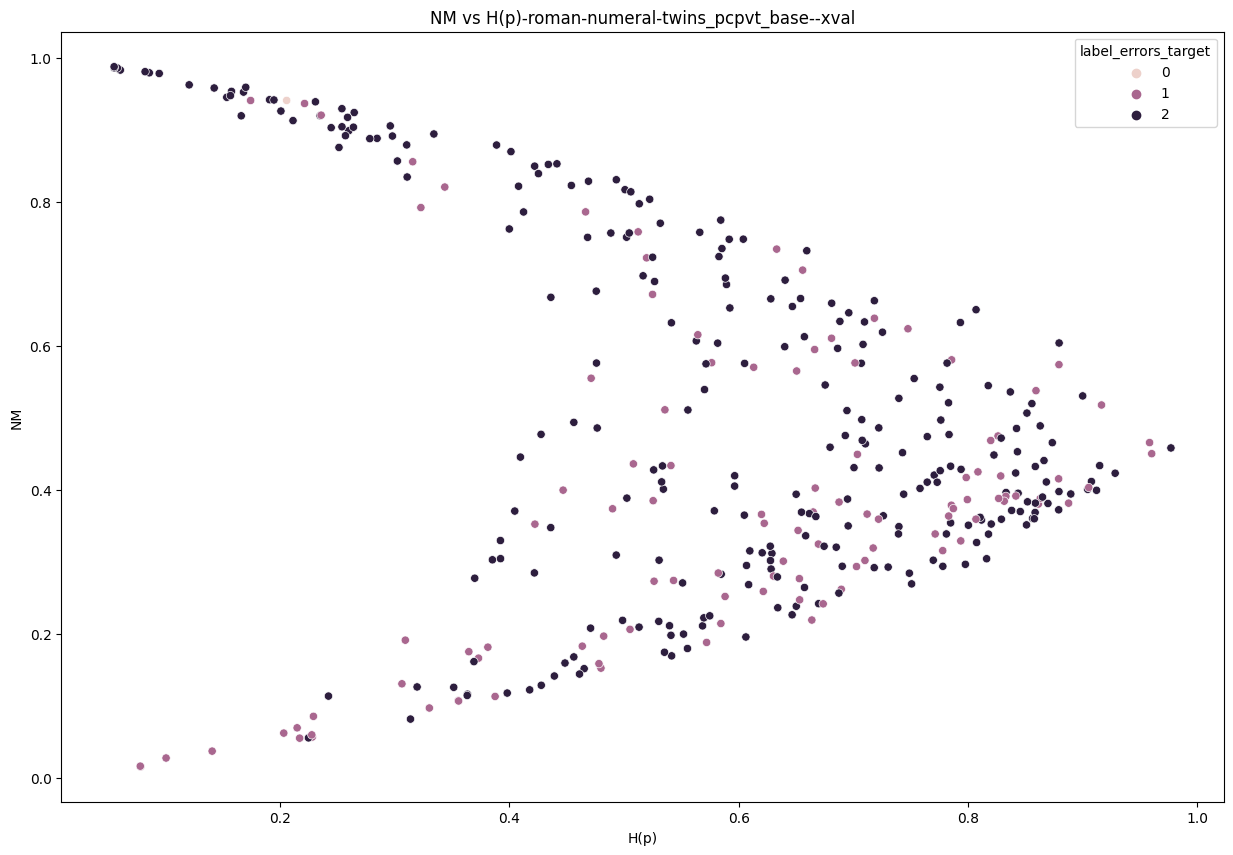

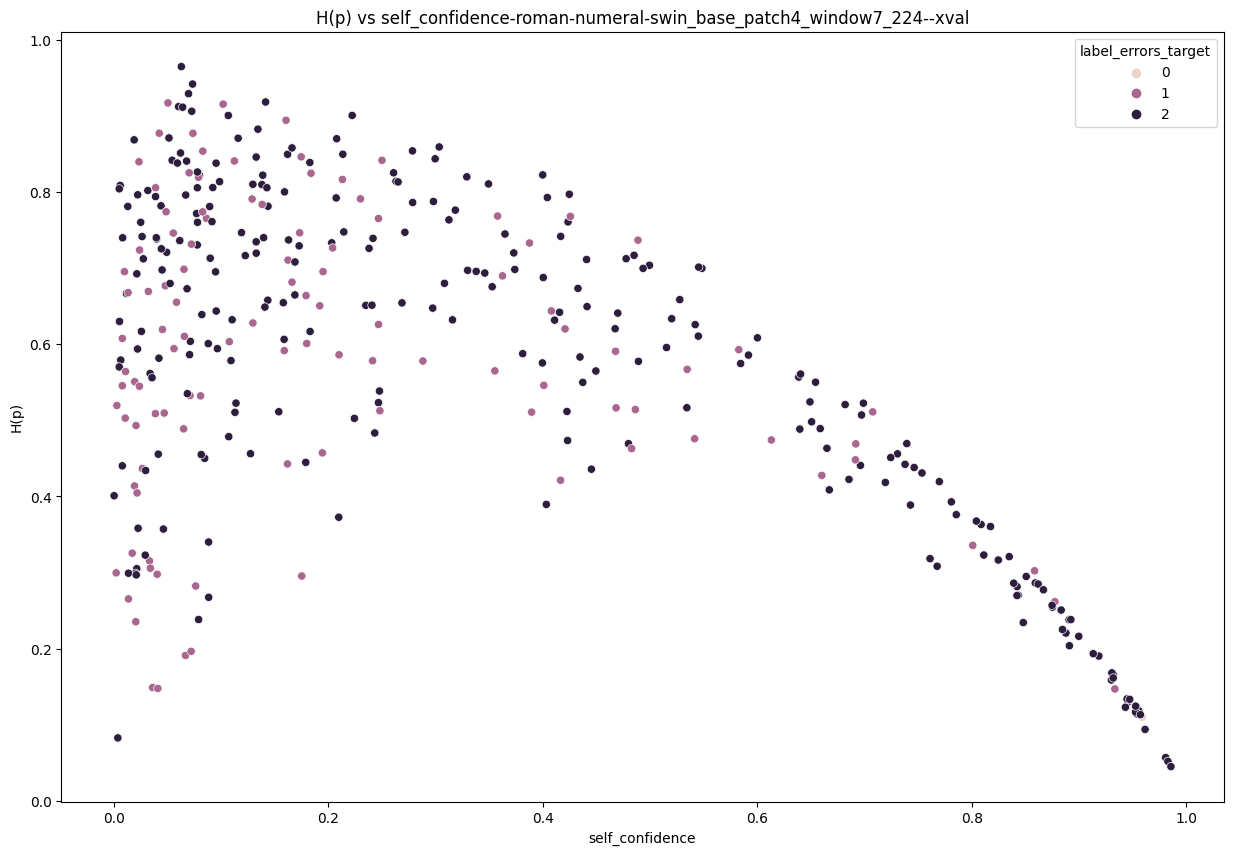

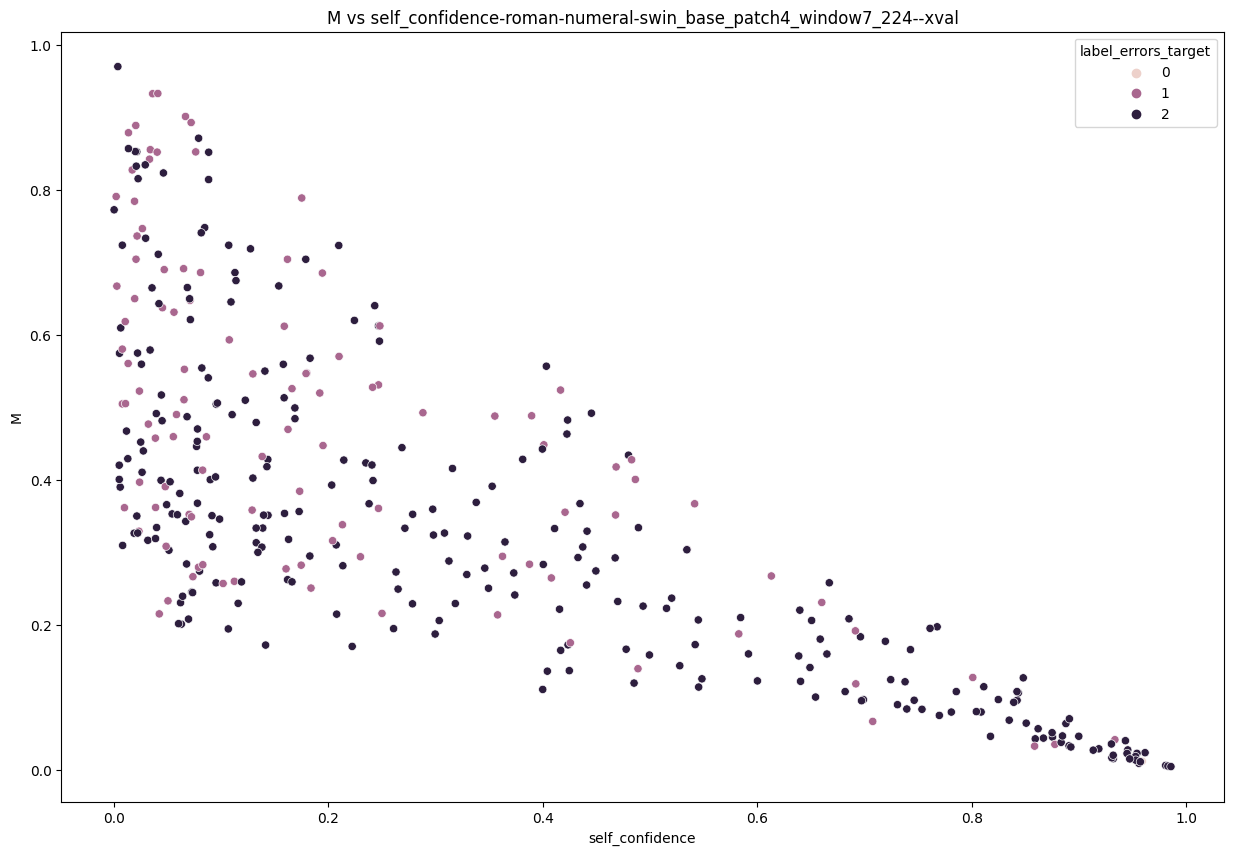

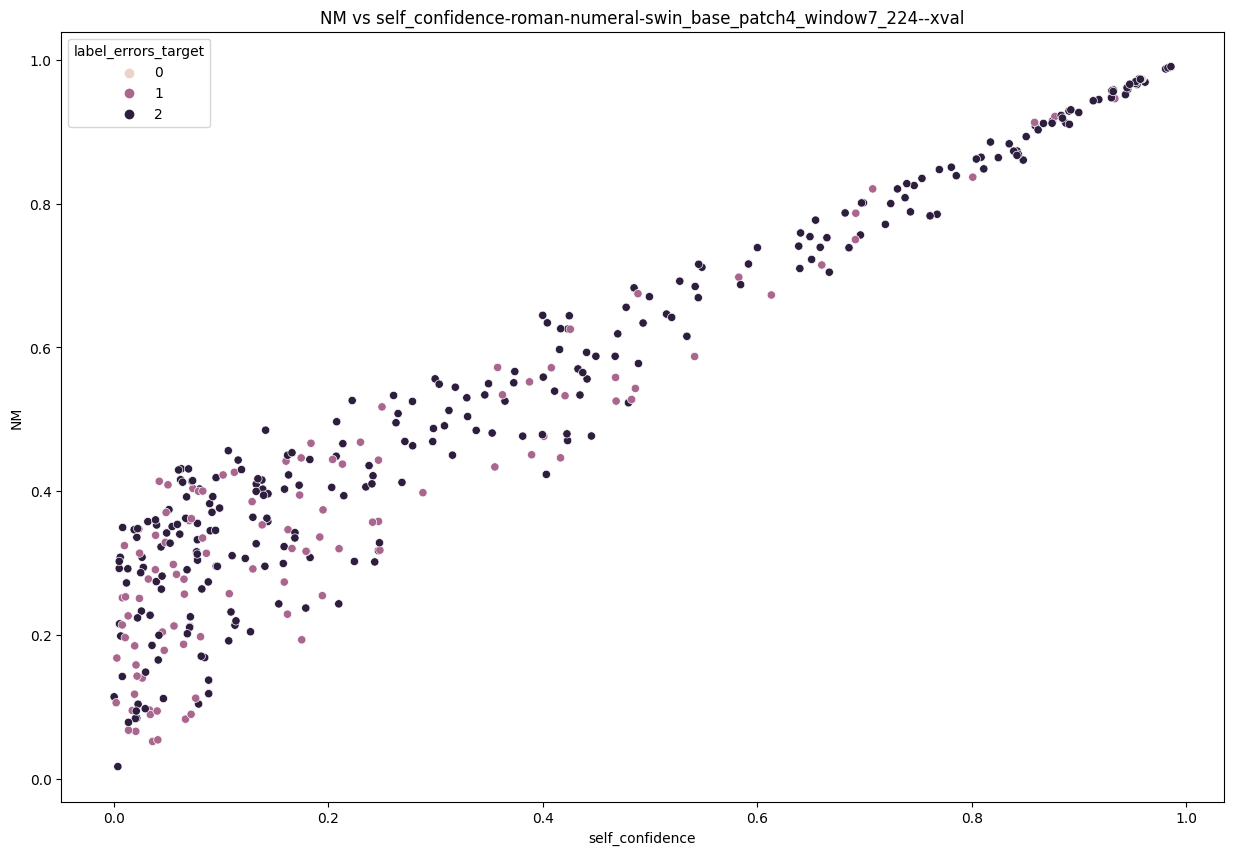

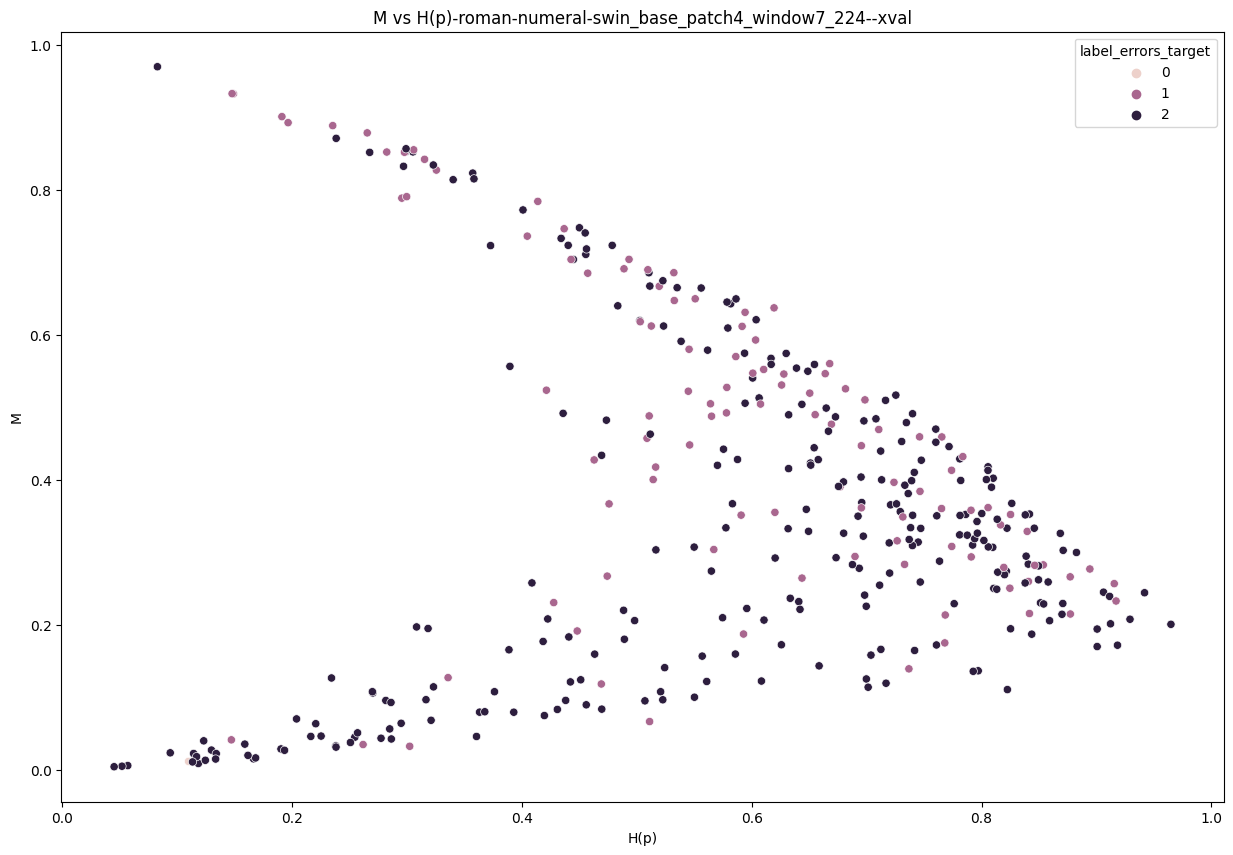

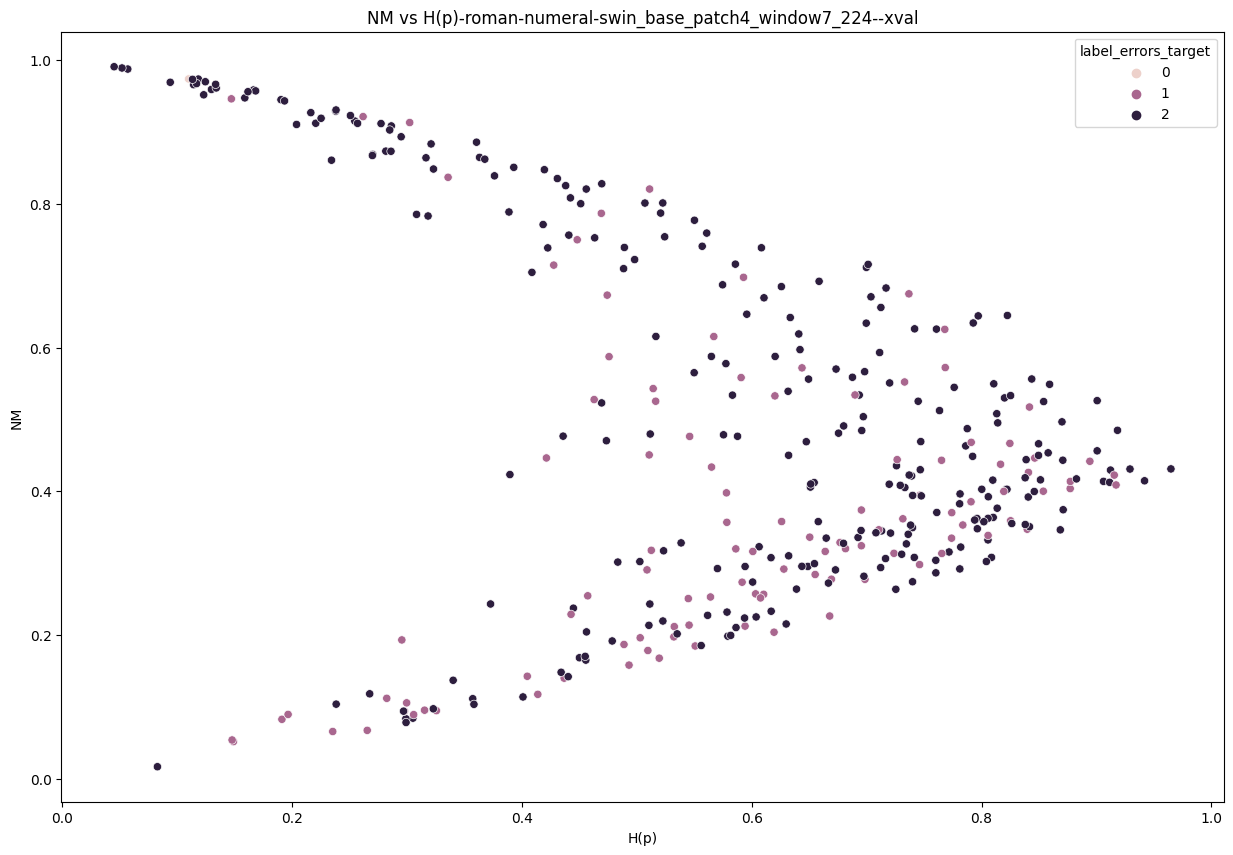

In [114]:
import seaborn as sns

for model, values, self_confidence, label_errors_target in results:
    plt.rcParams["figure.figsize"] = (15, 10)
    df = pd.DataFrame(zip(self_confidence, values, label_errors_target), columns=['self_confidence','y','label_errors_target'])  
    sns.scatterplot(x="self_confidence", y="y", data=df, hue='label_errors_target')
    axis_titles = model.split("-")[0]
    y_axis, _, x_axis = axis_titles.split(" ")
    plt.title(f'{model}')
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)
#     plt.savefig(f'./figs-test/scatter-{model}.png', dpi=100)
    plt.show()

## Evaluate all results from individual models

# Real Start

In [ ]:
from cleanlab.internal.label_quality_utils import get_normalized_entropy
from sklearn.metrics import mutual_info_score
from scipy.stats import chi2_contingency #mi

def penalized_confidence(labels, pred_probs, adjust_pred_probs=False):
#     self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
#     given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
#     given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
#     more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
#     J = np.sum(more_likeley, axis=1)
#     return self_confidence / J

    alpha=0.50
    mask = pred_probs.copy()
    mask[np.arange(mask.shape[0]), labels] = -1
    pred_probs_prime = mask[mask != -1]
    pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
    normalized_entropy = get_normalized_entropy(pred_probs_prime)
    
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
    given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
    more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
    J = np.sum(more_likeley, axis=1)
    K = len(set(labels))
    rank  = ((K - J) / K ) * normalized_entropy
    return alpha * self_confidence + (1 - alpha) * rank
    

def rank_penalized_confidence(labels, pred_probs, adjust_pred_probs=False, alpha=0.50):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
    given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
    more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
    J = np.sum(more_likeley, axis=1)
    K = len(set(labels))
    rank  = (K - J) / K
    return alpha * self_confidence + (1 - alpha) * rank

# def ratio_confidence(labels, pred_probs, adjust_pred_probs=False):
#     self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
#     given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
#     next_most_likeley_label_prob = 
#     J = given_label_prob / next_most_likeley_label_prob
#     given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
#     more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
#     J = np.sum(more_likeley, axis=1)
#     return self_confidence / J

def mutual_info(labels, pred_probs, adjust_pred_probs=False):
    print(pred_probs.shape, np.min(pred_probs), np.max(pred_probs))
    mi = mutual_info_score(labels_true=labels, labels_pred=pred_probs.argmax(axis=1), contingency=None)
    print(mi.shape, np.min(mi), np.max(mi))
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)    
    return self_confidence / mi

# Use self_confidence of p^ where for each example: 
# p^ = (K+1)-dimensional vector, first K entries correspond to our K classes, final entry correponds to an “other” class.
# For i-th example: 
# first K entries of p^ = pred_probs[i]*p_in & final entry = (1-p_in)
# Here p_in = probability that one of the K classes is appropriate, so 1-p_in = probability that none are (class should be “other”).  
# For now, can use heuristic that p_in = max(pred_probs[i]) which is a common choice in open-set cognition

def openset_score(labels, pred_probs, adjust_pred_probs=False):
    p_in = np.amax(pred_probs, axis=1)
    p_hat = np.zeros((pred_probs.shape[0], pred_probs.shape[1]+1))
    p_hat[:,:-1] = pred_probs * p_in[:,np.newaxis]
    p_hat[:,-1] = 1 - p_in
    self_confidence = get_label_quality_scores(labels, p_hat, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    print(np.min(self_confidence),np.max(self_confidence), np.mean(self_confidence))
    return self_confidence

def openset_entropy_score(labels, pred_probs, adjust_pred_probs=False):
    # conf weighted entropy but stronger adj
    p_in = 1.0 - get_normalized_entropy(pred_probs)
    p_hat = np.zeros((pred_probs.shape[0], pred_probs.shape[1]+1))
    p_hat[:,:-1] = pred_probs * p_in[:,np.newaxis]
    p_hat[:,-1] = 1 - p_in
    self_confidence = get_label_quality_scores(labels, p_hat, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    return self_confidence
#     mask = pred_probs.copy()
#     mask[np.arange(mask.shape[0]), labels] = -1
#     pred_probs_prime = mask[mask != -1]
#     pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))

#     p_in = np.amax(pred_probs, axis=1)
    
#     p_hat = np.zeros((pred_probs.shape[0], pred_probs.shape[1]+1))
#     p_hat[:,:-1] = pred_probs * p_in[:,np.newaxis]
#     p_hat[:,-1] = 1 - p_in
    
#     self_confidence = get_label_quality_scores(labels, p_hat, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    
#     normalized_entropy = get_normalized_entropy(pred_probs_prime)
#     x = np.abs(0.5 - normalized_entropy)
#     self_confidence = (self_confidence / x ) * 0.5
#     print(np.min(self_confidence),np.max(self_confidence), np.mean(self_confidence))
#     return self_confidence

# Idea we are allowing an extra set that encompasses both the true prediction and none of the above
def openset_entropy_prime_score(labels, pred_probs, adjust_pred_probs=False):
    mask = pred_probs.copy()
    mask[np.arange(mask.shape[0]), labels] = -1
    pred_probs_prime = mask[mask != -1]
    pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
    
    p_in = np.amax(pred_probs, axis=1)
    
    p_hat = np.zeros((pred_probs_prime.shape[0], pred_probs_prime.shape[1]+1))
    p_hat[:,:-1] = pred_probs_prime * p_in[:,np.newaxis]
    p_hat[:,-1] = 1 - p_in
    
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    
    normalized_entropy = get_normalized_entropy(p_hat)
    x = np.abs(0.5 - normalized_entropy)
    self_confidence = (self_confidence / x ) * 0.5
    print(np.min(self_confidence),np.max(self_confidence), np.mean(self_confidence))
    
    return self_confidence

def entropic_confidence(labels, pred_probs, adjust_pred_probs=False):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    mask = pred_probs.copy()
    mask[np.arange(mask.shape[0]), labels] = -1
    pred_probs_prime = mask[mask != -1]
    pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
    pred_probs_prime = pred_probs_prime / np.sum(pred_probs_prime, axis=1)[:,np.newaxis]

    normalized_entropy = get_normalized_entropy(pred_probs_prime)
    return self_confidence / normalized_entropy
#     x = np.abs(0.5 - normalized_entropy)
#     return (self_confidence / x ) * 0.5

# p_y + A * c(p') where:
# p_y = the probability of given label in original pred_prob vector
#  p' = the renormalized probability vector for this example after removing the given label y from the pred_prob for this example
#  c(p') = min { H(p'), 1-H(p') }
# with H= normalized_entropy
# A  = hyperparameter, say try: 0.001, 0.01, 0.1, 1 
                          
def balanced_entropic_confidence(labels, pred_probs, adjust_pred_probs=False, alpha=1):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    mask = pred_probs.copy()
    mask[np.arange(mask.shape[0]), labels] = -1
    pred_probs_prime = mask[mask != -1]
    pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
    pred_probs_prime = pred_probs_prime / np.sum(pred_probs_prime, axis=1)[:,np.newaxis]

    normalized_entropy = get_normalized_entropy(pred_probs_prime)
    
    given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
    c = np.amin([normalized_entropy, 1 - normalized_entropy], axis=0)
    return given_label_prob + alpha * c

# def likelihood_ratio(labels, pred_probs, adjust_pred_probs=False):
#     # p_k = p(marginal over classes k), p_y = pred probs
#     p_k = np.array([np.sum(labels == k)/len(labels) for k in set(labels)])
#     p_k = np.repeat(p_k[np.newaxis], repeats=len(labels), axis=0)
#     p_k = np.log(p_k)
#     likeleyhood_ratio_score = p_k - np.log(pred_probs)
#     return np.mean(likeleyhood_ratio_score, axis=1)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from mapie.classification import MapieClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class FakeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, pred_probs=None):
        self.pred_probs = pred_probs

    def predict(self, X):
        print('predict called')
        return self.pred_probs
        
    def fit(self, X, y):
        print('fit called')
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        return self

    def predict_proba(self, X):
        print(f'predict_proba called {X.shape}, {self.pred_probs.shape}')
        return self.pred_probs

In [ ]:
def conformal_score_adjust(labels, pred_probs, adjust_pred_probs=False, alpha=0.01):
    centers = [(0, 3.5), (-2, 0), (2, 0)]
    covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
    x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
    n_samples = len(labels)
    n_classes = pred_probs.shape[1]
    np.random.seed(42)
    X = np.random.random((n_samples,n_classes))
    y = np.random.randint(low=0, high=10, size=(n_samples,))

    X_train_cal, X_test, y_train_cal, y_test = X, X.copy(), y, y.copy()
    X_train, X_cal, y_train, y_cal = X, X.copy(), y, y.copy()

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
    )
    X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)

    clf = FakeClassifier(pred_probs)
    clf.fit(pred_probs, labels)
    mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
    mapie_score.fit(X_cal, y_cal)
    alpha2 = np.arange(0.02, 0.98, 0.02)
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    
    widths_score = np.sum(y_ps_score2, axis=1)
    widths_score = np.mean(widths_score, axis=1)
    
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    
    return self_confidence + alpha * widths_score

def conformal_score(labels, pred_probs, adjust_pred_probs=False):
    # fake data copy paste for conformal score (to pass mapie internal checks)
    centers = [(0, 3.5), (-2, 0), (2, 0)]
    covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
    x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
    n_samples = len(labels)
    n_classes = pred_probs.shape[1]
    np.random.seed(42)
    X = np.random.random((n_samples,n_classes))
    y = np.random.randint(low=0, high=10, size=(n_samples,))

    X_train_cal, X_test, y_train_cal, y_test = X, X.copy(), y, y.copy()
    X_train, X_cal, y_train, y_cal = X, X.copy(), y, y.copy()

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
    )
    X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)
    
    # actual conformal score
    clf = FakeClassifier(pred_probs)
    clf.fit(pred_probs, labels)
    mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
    mapie_score.fit(X_cal, y_cal)
    alpha2 = np.arange(0.02, 0.98, 0.02)
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    
    widths_score = np.sum(y_ps_score2, axis=1)
    widths_score = np.mean(widths_score, axis=1)
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    
    return self_confidence * widths_score


In [ ]:
from mapie.metrics import classification_mean_width_score
from sklearn.metrics.pairwise import euclidean_distances

def magl_mult(labels, pred_probs, adjust_pred_probs=False):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    magl = np.sum(np.clip(pred_probs - self_confidence[:,np.newaxis], a_min=0, a_max=None), axis=1)
    return self_confidence * (1 - magl)

def magl_adjust(labels, pred_probs, adjust_pred_probs=False, alpha=0.0003):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    magl = np.sum(np.clip(pred_probs - self_confidence[:,np.newaxis], a_min=0, a_max=None), axis=1)
    return (1-alpha) * self_confidence + alpha * (1-magl)

def likelihood_ratio(labels, pred_probs, adjust_pred_probs=False):
    p_y = pred_probs[np.arange(pred_probs.shape[0]), labels]
    p_y = np.repeat(p_y[:,np.newaxis], pred_probs.shape[1], axis=1)
    likeleyhood_ratio_score = np.log(pred_probs) - np.log(p_y)
    return 1 - np.mean(likeleyhood_ratio_score, axis=1)

def likelihood_confidence_ratio(labels, pred_probs, adjust_pred_probs=False, alpha=0.0003):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    likeleyhood_ratio_score = likelihood_ratio(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
    return (1-alpha) * self_confidence + alpha * (1 - likeleyhood_ratio_score)

def confidence_with_noclass(labels, pred_probs, adjust_pred_probs=False):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    p_k = np.array([np.sum(labels == k)/len(labels) for k in set(labels)])
    p_none = np.prod(1 - p_k)
    return self_confidence * (1 - p_none)

def confidence_with_noclass_entropy(labels, pred_probs, adjust_pred_probs=False):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    normalized_entropy = get_normalized_entropy(pred_probs)
    c = np.mean(np.max(pred_probs, axis=1)) / np.mean(1 - normalized_entropy)
    p_none = normalized_entropy * c
    return self_confidence * (1 - p_none)

def confidence_with_noclass_gap(labels, pred_probs, adjust_pred_probs=False):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    normalized_entropy = get_normalized_entropy(pred_probs)
    c = np.mean(np.max(pred_probs, axis=1)) / np.mean(1 - normalized_entropy)
    p_diff = np.partition(pred_probs, -2, axis=1)[:,-2:]
    p_none = c * (p_diff[:,1] - p_diff[:,0])
    return self_confidence * (p_none)

def centroid_distance(labels, pred_probs, adjust_pred_probs=False):
    J = [np.where(labels == k)[0] for k in range(len(set(labels)))]
    J_y = [J[int(label)] for label in labels]
    vector_y = np.array([np.mean(pred_probs[J_y[i]], axis=0) for i in range(len(labels))])
    score = -1 * np.linalg.norm(pred_probs-vector_y, axis=1)
    return score

def epistemic_uncertainty(labels, pred_probs_list, adjust_pred_probs=False, alpha=0.1):
    # e_uncertainty = disagreement between individual models’ pred_probs
    self_confidence_list = []
    pred_probs_avg = np.squeeze(np.array(pred_probs_list).mean(axis=0))
    e_uncertainty = []
    
    for pred_probs in pred_probs_list:
        self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
        self_confidence_list.append(self_confidence)
        e_uncertainty.append(euclidean_distances(pred_probs_avg, pred_probs))
        
    self_confidence_list = np.array(self_confidence_list)
    self_confidence = self_confidence_list.mean(axis=1)
    
    e_uncertainty = np.array(e_uncertainty)
    e_uncertainty = e_uncertainty.mean(axis=1)
    
    score = self_confidence + alpha * (0.5 - self_confidence) * e_uncertainty
    return score
    

In [ ]:
# dictionaries to map to display name
method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
    "magl-False": "Mass Above Given Label",
    "penalized_confidence-False": "Penalized Confidence",
    "rank_penalized_confidence-False": "Rank Penalized Confidence",
    "balanced_entropic_confidence-False": "Balanced Entropic Confidence",
    "entropic_confidence-False": "Entropic Confidence",
    "openset_score-False": "Openset Score",
    "openset_entropy_score-False": "Openset Entropy Score",
    "openset_entropy_prime_score-False": "Openset Entropy Prime Score",
    "mutual_info-False": "MI Confidence",
    "magl_mult-False": "MAGL mult",
    "magl_adjust-False": "MAGL adjust",
    "likelihood_ratio-False": "Likelihood Ratio",
    "likelihood_confidence_ratio-False": "Likelihood Confidence Ratio",
    "confidence_with_noclass-False": "CWNC",
    "confidence_with_noclass_entropy-False": "CWNC Entropy",
    "confidence_with_noclass_gap-False": "CWNC Gap",
    "centroid_distance-False": "Centroid Distance",
    "conformal_score-False": "Conformal Score",
    "conformal_score_adjust-False": "Conformal Score Adjust",
    "epistemic_uncertainty-False": "Epistemic Uncertainty",
}

model_display_name_dict = {
    "swin_base_patch4_window7_224": "Swin Transformer",
    "twins_pcpvt_base": "Twins PCPVT",
    "efficientnet_b1": "EfficientNet-B1",
    "resnet50d": "ResNet-50d",
    "resnet18": "ResNet-18",
}

In [ ]:
%%time

def eval_exp(experiments, score_params):
    evaluations = []
    precision_recall_curves = [] # store this separately
    accuracy_list = []

    for experiment in experiments:

        # experiment results
        dataset = experiment["dataset"]
        model = experiment["model"]
        pred_probs = experiment["pred_probs"]
        labels = experiment["labels"]
        images = experiment["images"]
        label_errors_target = experiment["label_errors_mask"]
        type_train = experiment["type_train"]

        accuracy = {
            "dataset": dataset,
            "model": model,
            "cv_accuracy": (pred_probs.argmax(axis=1) == labels).mean()
        }

        accuracy_list.append(accuracy)

        # finding label issues (score param agnostic)
        find_label_issues = cleanlab.filter.find_label_issues(labels, pred_probs, filter_by='confident_learning')
        num_label_issues = cleanlab.count.num_label_issues(labels, pred_probs)

        for score_param in score_params:        
            # compute scoring method
            method, adjust_pred_probs, alpha = score_param
            
            if method == "epistemic_uncertainty":
                continue #ensemble methods

            if method == "magl":
                label_quality_scores = probability_mass_above_given_label_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=alpha)
            elif method == "penalized_confidence":
                label_quality_scores = penalized_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method == "entropic_confidence":
                label_quality_scores = entropic_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif "balanced_entropic_confidence" in method:
                label_quality_scores = balanced_entropic_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=alpha)
            elif "rank_penalized_confidence" in method:
                label_quality_scores = rank_penalized_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=alpha)
            elif method == "openset_score":
                label_quality_scores = openset_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method == "openset_entropy_score":
                label_quality_scores = openset_entropy_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method == "openset_entropy_prime_score":
                label_quality_scores = openset_entropy_prime_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method =="mutual_info":
                label_quality_scores = mutual_info(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method =="magl_mult":
                label_quality_scores = magl_mult(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method=="magl_adjust":
                label_quality_scores = magl_adjust(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method=="likelihood_ratio":
                label_quality_scores = likelihood_ratio(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method=="likelihood_confidence_ratio":
                label_quality_scores = likelihood_confidence_ratio(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method=="confidence_with_noclass":
                label_quality_scores = confidence_with_noclass(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method=="confidence_with_noclass_entropy":
                label_quality_scores = confidence_with_noclass_entropy(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method=="confidence_with_noclass_gap":
                label_quality_scores = confidence_with_noclass_gap(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method=="centroid_distance":
                label_quality_scores = centroid_distance(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            elif method=="conformal_score_adjust":
                label_quality_scores = conformal_score_adjust(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=alpha)
            elif method=="conformal_score":
                label_quality_scores = conformal_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
            else:
                label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

            # compute accuracy of detecting label errors
            auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

            # compute precision-recall curve using label quality scores
            precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

            # compute prc auc scores
            auprc = auc(recall, precision)

            # lift at K where K = number of label errors
            lift_at_num_label_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())

            # lift at k=100
            lift_at_100 = lift_at_k(label_errors_target, 1 - label_quality_scores, k=100)

            evaluation_results = {
                "method": method,
                "adjust_pred_probs": adjust_pred_probs,
                "dataset": dataset,
                "model": model,
                "dataset_num_samples": labels.shape[0],
                "dataset_num_label_errors": label_errors_target.sum(),
                "auroc": auroc,
                "auprc": auprc,
                "MAE_label_issues": np.sum(np.abs(find_label_issues ^ label_errors_target)) / len(find_label_issues),
                "confident_MAD": np.abs(np.sum(find_label_issues) - np.sum(label_errors_target)),
                "estimated_MAD": np.abs(num_label_issues - np.sum(label_errors_target)),
                "lift_at_num_label_errors": lift_at_num_label_errors,
                "lift_at_100": lift_at_100,
                "type_train": type_train,
            }

            # store evaluation results
            evaluations.append(evaluation_results)

            precision_recall_curve_results = {
                "method": method,
                "adjust_pred_probs": adjust_pred_probs,
                "dataset": dataset,
                "model": model,
                "label_quality_scores": label_quality_scores,
                "precision": precision,
                "recall": recall,
                "thresholds": thresholds,
                "type_train": type_train,
            }

            # store precision-recall curve results
            precision_recall_curves.append(precision_recall_curve_results)
            
    return evaluations, precision_recall_curves, accuracy_list


In [ ]:
%%time

def build_ensemble_eval(experiments):
    ensemble_experiments = {}

    for experiment in experiments:

        # experiment results
        dataset = experiment["dataset"]
        if dataset not in ensemble_experiments.keys():
            ensemble_experiments[dataset] = []
        ensemble_experiments[dataset].append(experiment)
    return ensemble_experiments

def ensemble_eval(ensemble_experiments, score_params, evaluations=[], precision_recall_curves=[], accuracy_list=[]):
    ensemble_experiments = build_ensemble_eval(experiments)
    
    for dataset, ensemble_experiment in ensemble_experiments.items():
        model = "ensemble"
        pred_probs_list = []
        labels = ensemble_experiment[0]["labels"]
        images = ensemble_experiment[0]["images"]
        label_errors_target = ensemble_experiment[0]["label_errors_mask"]
        type_train = ensemble_experiment[0]["type_train"]
        
        accuracies = []
        
        for experiment in ensemble_experiment:
            pred_probs = experiment["pred_probs"]
            pred_probs_list.append(pred_probs)
            accuracies.append((pred_probs.argmax(axis=1) == labels).mean())
        
        accuracy = {
            "dataset": dataset,
            "model": "ensemble",
            "cv_accuracy": np.array(accuracies).mean()
        }

        accuracy_list.append(accuracy)
        
        for score_param in score_params:        
            # compute scoring method
            method, adjust_pred_probs, alpha = score_param

            if method == "epistemic_uncertainty":
                label_quality_scores = epistemic_uncertainty(labels, pred_probs_list, adjust_pred_probs=adjust_pred_probs, alpha=alpha)
            
            # compute accuracy of detecting label errors
            auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

            # compute precision-recall curve using label quality scores
            precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

            # compute prc auc scores
            auprc = auc(recall, precision)

            # lift at K where K = number of label errors
            lift_at_num_label_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())

            # lift at k=100
            lift_at_100 = lift_at_k(label_errors_target, 1 - label_quality_scores, k=100)

            evaluation_results = {
                "method": method,
                "adjust_pred_probs": adjust_pred_probs,
                "dataset": dataset,
                "model": model,
                "dataset_num_samples": labels.shape[0],
                "dataset_num_label_errors": label_errors_target.sum(),
                "auroc": auroc,
                "auprc": auprc,
                "MAE_label_issues": np.sum(np.abs(find_label_issues ^ label_errors_target)) / len(find_label_issues),
                "confident_MAD": np.abs(np.sum(find_label_issues) - np.sum(label_errors_target)),
                "estimated_MAD": np.abs(num_label_issues - np.sum(label_errors_target)),
                "lift_at_num_label_errors": lift_at_num_label_errors,
                "lift_at_100": lift_at_100,
                "type_train": type_train,
            }

            # store evaluation results
            evaluations.append(evaluation_results)

            precision_recall_curve_results = {
                "method": method,
                "adjust_pred_probs": adjust_pred_probs,
                "dataset": dataset,
                "model": model,
                "label_quality_scores": label_quality_scores,
                "precision": precision,
                "recall": recall,
                "thresholds": thresholds,
                "type_train": type_train,
            }

            # store precision-recall curve results
            precision_recall_curves.append(precision_recall_curve_results)
            
    return evaluations, precision_recall_curves, accuracy_list


In [ ]:
def vis_results(evaluations, new_methods):
    dfs = []
    df = pd.DataFrame(evaluations)
    for method in new_methods:
        gt = df.loc[df['method']=='self_confidence'].loc[df['adjust_pred_probs']==False]
        new_method = df.loc[df['method']==method].loc[df['adjust_pred_probs']==False]
        scores = ['auroc','auprc','lift_at_num_label_errors','lift_at_100']
        results = pd.DataFrame(new_method[scores].to_numpy() - gt[scores].to_numpy(), columns=scores).reset_index(drop=True)
        info = new_method[['method','adjust_pred_probs','dataset','model','dataset_num_samples','dataset_num_label_errors']].reset_index(drop=True)
        results = pd.concat([info,results],axis=1).rename(columns=dict(zip(scores, ['Δauroc','Δauprc','Δlift_at_num_label_errors','Δlift_at_100'])))
        results['method'] = f'{method} - self_confidence'
        dfs.append(results)

    dfs_new_methods_results = pd.concat(dfs)
    return dfs_new_methods_results

In [ ]:
import seaborn as sns

def scatterplot(df, method, hue='dataset'):
    plt.figure(figsize=(8,8))
    method = f'{method} - self_confidence'
    auroc = df.loc[df['method']==method]['Δauroc']
    auprc = df.loc[df['method']==method]['Δauprc'].tolist()
    hue_vals = df.loc[df['method']==method][hue].tolist()
    df = pd.DataFrame(zip(auroc, auprc, hue_vals), columns=['auroc','auprc',hue])
    
    plt.axline((0,0), slope=0)
    plt.axline((0,0), slope=float("inf"))

    sns.scatterplot(x="auroc", y="auprc", data=df, hue=hue)
    
    plt.title(f'auroc-auprc-{method}')
    plt.savefig(f'./figs/scatter-aurocprc-{method}-{len(df)}.png', dpi=300)
    plt.show()

## Plotting Lift/AUROC Plots for New Methods

In [ ]:
def create_mixed_df(df, accuracy_list, delta=False):
    if delta:
        change='Δ'
    else:
        change=''
    df_cv_accuracy = pd.DataFrame(accuracy_list)
    df = df.merge(df_cv_accuracy, how="left", on=["dataset", "model"])
    df.head()
    df["method_adjust_pred_probs"] = (
        df.method + "-" + df.adjust_pred_probs.astype(str)
    )
    df["dataset_model"] = df.dataset + " | " + df.model

    df["scoring_method"] = df.method_adjust_pred_probs.map(
        lambda x: method_adjust_pred_probs_display_dict[x]
    )
    df["model_name"] = df.model.map(
        lambda x: model_display_name_dict[x]
    )

    df["model_name_w_acc"] = df.model_name + " (" + df.cv_accuracy.round(4).astype(str) + ") "

    df_auroc = (
        pd.pivot_table(
            df,
            values=f"{change}auroc",
            index=["dataset", "model_name", "model_name_w_acc"],
            columns=["scoring_method"],
        )
        .reset_index()
        .sort_values(by=["dataset", "model_name"])
    )
    
    df_auprc = (
        pd.pivot_table(
            df,
            values=f"{change}auprc",
            index=["dataset", "model_name", "model_name_w_acc"],
            columns=["scoring_method"],
        )
        .reset_index()
        .sort_values(by=["dataset", "model_name"])
    )  

    df_lift_at_num_errors = (
        pd.pivot_table(
            df,
            values=f"{change}lift_at_num_label_errors",
            index=["dataset", "model_name", "model_name_w_acc"],
            columns=["scoring_method"],
        )
        .reset_index()
        .sort_values(by=["dataset", "model_name"])
    )

    df_lift_at_100 = (
        pd.pivot_table(
            df,
            values=f"{change}lift_at_100",
            index=["dataset", "model_name", "model_name_w_acc"],
            columns=["scoring_method"],
        )
        .reset_index()
        .sort_values(by=["dataset", "model_name"])
    )
    
    return df_auroc,df_auprc, df_lift_at_num_errors, df_lift_at_100

In [ ]:
def draw_full_plot_lift(df, title="LIFT", alpha=1, markersize=8):
    # pointer
    df = df.sort_values(by=["dataset", "Self Confidence"])
    df["dataset_model"] = df.dataset + " | " + df.model_name_w_acc

    labels = df["dataset_model"].tolist()
    x = np.arange(len(labels))  # the label locations

#     s0 = df["Confidence Weighted Entropy"].tolist()
    s1 = df["Self Confidence"].tolist()
#     s2 = df["Adjusted Self Confidence"].tolist()
#     s3 = df["Normalized Margin"].tolist()
#     s4 = df["Adjusted Normalized Margin"].tolist()
#     s5 = df['Mass Above Given Label'].tolist()
#     s6 = df['Entropic Confidence'].tolist()
#     s7 = df['Balanced Entropic Confidence'].tolist()
#     s8 = df['Openset Score'].tolist()
#     s9 = df['Openset Entropy Score'].tolist()
#     s10 = df['Openset Entropy Prime Score'].tolist()
#     s11 = df['Penalized Confidence'].tolist()
#     s12 = df['Rank Penalized Confidence'].tolist()
    s13 = df['MAGL mult'].tolist()
    s14 = df['MAGL adjust'].tolist()
    s15 = df['Likelihood Ratio'].tolist()
    s19 = df['Likelihood Confidence Ratio'].tolist()
    s16 = df['CWNC'].tolist()
    s17 = df['CWNC Entropy'].tolist()
    s18 = df['CWNC Gap'].tolist()
    s19 = df['Centroid Distance'].tolist()
    s20 = df["Conformal Score"].tolist()
    s21 = df['Epistemic Uncertainty'].tolist()
    s22 = df["Conformal Score Adjust"].tolist()

    jf = 0.15 # jitter factor

    fig, ax = plt.subplots()
#     _ = ax.plot(s0, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Confidence Weighted Entropy", markersize=markersize, alpha=alpha)
    _ = ax.plot(s1, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Self Confidence", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s2, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Self Confidence", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s3, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Normalized Margin", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s4, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Normalized Margin", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s5, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Mass Above Given Label", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s6, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Entropic Confidence", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s7, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Balanced Entropic Confidence", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s8, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Openset Score", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s9, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Openset Entropy Score", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s10, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Openset Entropy Prime Score", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s11, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Penalized Confidence", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s12, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Rank Penalized Confidence", markersize=markersize, alpha=alpha)
    _ = ax.plot(s13, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="MAGL mult", markersize=markersize, alpha=alpha)
    _ = ax.plot(s14, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="MAGL adjust", markersize=markersize, alpha=alpha)
    _ = ax.plot(s15, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Likelihood Ratio", markersize=markersize, alpha=alpha)
    _ = ax.plot(s19, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Likelihood Confidence Ratio", markersize=markersize, alpha=alpha)
    _ = ax.plot(s16, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="CWNC", markersize=markersize, alpha=alpha)
    _ = ax.plot(s17, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="CWNC Entropy", markersize=markersize, alpha=alpha)
    _ = ax.plot(s18, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="CWNC Gap", markersize=markersize, alpha=alpha)
    _ = ax.plot(s19, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Centroid Distance", markersize=markersize, alpha=alpha)
    _ = ax.plot(s20, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Conformal Score", markersize=markersize, alpha=alpha)
    _ = ax.plot(s21, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Epistemic Uncertainty", markersize=markersize, alpha=alpha)
    _ = ax.plot(s22, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Conformal Score Adjust", markersize=markersize, alpha=alpha)

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Dataset | Model(accuracy)")
    ax.set_title(title, fontsize=24, fontweight="bold")
    ax.set_yticks(x, labels)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    
    # plot horizontal lines between each model group
    a = [(x[i] + x[i+1]) / 2 for i in range(4,len(x)-4,5)]    
    [ax.axhline(y=i, linestyle='solid',c='black',linewidth=0.75) for i in a]

    fig.tight_layout()
#     plt.savefig(f'./figs/scatter-full-{title}.png', dpi=300)
    plt.show()

In [ ]:
def draw_dot_plot(df, title="LIFT", alpha=1, markersize=8):
    plt.rcParams["figure.figsize"] = (15, 10)

    # pointer
    df = df.sort_values(by=["dataset", "Self Confidence"]) # sort on y-axis
    df["dataset_model"] = df.dataset + " | " + df.model_name_w_acc # title fot y axis per model

    labels = df["dataset_model"].tolist()
    x = np.arange(len(labels))  # the label locations

    s0 = df["Confidence Weighted Entropy"].tolist()
    s1 = df["Self Confidence"].tolist()
    s2 = df["Adjusted Self Confidence"].tolist()
    s3 = df["Normalized Margin"].tolist()
    s4 = df["Adjusted Normalized Margin"].tolist()

    jf = 0.15 # jitter factor

    fig, ax = plt.subplots()
    _ = ax.plot(s0, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Confidence Weighted Entropy", markersize=markersize, alpha=alpha)
    _ = ax.plot(s1, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Self Confidence", markersize=markersize, alpha=alpha)
    _ = ax.plot(s2, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Self Confidence", markersize=markersize, alpha=alpha)
    _ = ax.plot(s3, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Normalized Margin", markersize=markersize, alpha=alpha)
    _ = ax.plot(s4, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Normalized Margin", markersize=markersize, alpha=alpha)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Dataset | Model(accuracy)")
    ax.set_title(title, fontsize=24, fontweight="bold")
    ax.set_yticks(x, labels)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    
    # plot horizontal lines between each model group (in this case every 5 datasets we want a line)
    a = [(x[i] + x[i+1]) / 2 for i in range(4,len(x)-4,5)]    
    [ax.axhline(y=i, linestyle='solid',c='black',linewidth=0.75) for i in a]

    fig.tight_layout()
#     plt.savefig(f'./figs/scatter-full-{title}.png', dpi=300)
    plt.show()

In [ ]:
def create_mixed_df(df, accuracy_list, delta=False):
    if delta:
        change='Δ'
    else:
        change=''
    df_cv_accuracy = pd.DataFrame(accuracy_list)
    df = df.merge(df_cv_accuracy, how="left", on=["dataset", "model"])
    df.head()
    df["method_adjust_pred_probs"] = (
        df.method + "-" + df.adjust_pred_probs.astype(str)
    )
    df["dataset_model"] = df.dataset + " | " + df.model

    df["scoring_method"] = df.method_adjust_pred_probs.map(
        lambda x: method_adjust_pred_probs_display_dict[x]
    )
    
    df["model_name"] = df.model 
#   If you want to map model arg names to better display names create dict and run below instead
#     method_adjust_pred_probs_display_dict = {
#      "self_confidence-False": "Self Confidence",
#      "self_confidence-True": "Adjusted Self Confidence",
#      "normalized_margin-False": "Normalized Margin",
#      "normalized_margin-True": "Adjusted Normalized Margin",
#      "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
#     }
#     df["model_name"] = df.model.map(
#         lambda x: model_display_name_dict[x]
#     )

    df["model_name_w_acc"] = df.model_name + " (" + df.cv_accuracy.round(4).astype(str) + ") "

    df_auroc = (
        pd.pivot_table(
            df,
            values=f"{change}auroc",
            index=["dataset", "model_name", "model_name_w_acc"],
            columns=["scoring_method"],
        )
        .reset_index()
        .sort_values(by=["dataset", "model_name"])
    )
    
    df_auprc = (
        pd.pivot_table(
            df,
            values=f"{change}auprc",
            index=["dataset", "model_name", "model_name_w_acc"],
            columns=["scoring_method"],
        )
        .reset_index()
        .sort_values(by=["dataset", "model_name"])
    )  

    df_lift_at_num_errors = (
        pd.pivot_table(
            df,
            values=f"{change}lift_at_num_label_errors",
            index=["dataset", "model_name", "model_name_w_acc"],
            columns=["scoring_method"],
        )
        .reset_index()
        .sort_values(by=["dataset", "model_name"])
    )

    df_lift_at_100 = (
        pd.pivot_table(
            df,
            values=f"{change}lift_at_100",
            index=["dataset", "model_name", "model_name_w_acc"],
            columns=["scoring_method"],
        )
        .reset_index()
        .sort_values(by=["dataset", "model_name"])
    )
    
    return df_auroc, df_auprc, df_lift_at_num_errors, df_lift_at_100

## Plotting Test

In [ ]:
# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False, 0),
    ("self_confidence", True, 0),
    ("normalized_margin", False, 0),
    ("normalized_margin", True, 0),
    ("confidence_weighted_entropy", False, 0),
]
    
evaluations, precision_recall_curves, accuracy_list = eval_exp(experiments, score_params)

evals = pd.DataFrame(evaluations)
df_auroc, df_auprc, df_lift_at_num_errors, df_lift_at_100 = create_mixed_df(evals, accuracy_list, delta=False)
draw_dot_plot(df_auroc, title="AUROC")

In [ ]:
evals.head(5)

In [ ]:
df_auroc.head(5)

In [ ]:
draw_dot_plot(df_auroc, title="AUROC")

### Plotting old methods + magl + entropic confidence

In [ ]:
# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False, 0),
#     ("self_confidence", True, 0),
#     ("normalized_margin", False, 0),
#     ("normalized_margin", True, 0),
#     ("confidence_weighted_entropy", False, 0),
#     ("entropic_confidence", False, 0),
#     ("balanced_entropic_confidence", False, 0.01),
#     ("rank_penalized_confidence", False, 0),
#     ("penalized_confidence", False, 0),    
#     ("magl", False, 0.001),
#     ("openset_score", False, 0),
#     ("openset_entropy_score", False, 0),
#     ("openset_entropy_prime_score", False, 0),
    ("epistemic_uncertainty", False, 0),
    ("conformal_score_adjust", False, 0),
    ("conformal_score", False, 0),

    ("magl_mult", False, 0),
#     ("magl_adjust", False, 0),
#     ("likelihood_ratio", False, 0),
#     ("likelihood_confidence_ratio", False, 0),
#     ("confidence_with_noclass", False, 0),
#     ("confidence_with_noclass_entropy", False, 0),
#     ("confidence_with_noclass_gap", False, 0),
    ("centroid_distance", False, 0),
]
    
evaluations, precision_recall_curves, accuracy_list = eval_exp(experiments, score_params)
evaluations, precision_recall_curves, accuracy_list = ensemble_eval(experiments, score_params, evaluations, precision_recall_curves, accuracy_list)

# dfs_new_methods_results = vis_results(evaluations, new_methods)
evals = pd.DataFrame(evaluations)

df_auroc, df_auprc, df_lift_at_num_errors, df_lift_at_100 = create_mixed_df(evals, accuracy_list, delta=False)
evals.head(50)

In [ ]:
from IPython.display import display, HTML

for dataset in set(evals['dataset'].tolist()):
    print(dataset)
    print(display(HTML(evals.loc[evals['dataset'] == dataset].describe().to_html())))

In [ ]:
draw_full_plot_lift(df_auroc, title="AUROC")
# ulya: log(self-confidence) - log(avg(p every other class))

In [ ]:
draw_full_plot_lift(df_auprc, title="AUPRC")

In [ ]:
draw_full_plot_lift(df_lift_at_num_errors, title="Lift at # Errors")

In [ ]:
draw_full_plot_lift(df_lift_at_100, title="Lift at 100")

## All ranking algorithms

In [ ]:
# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False, 0),
    ("rank_penalized_confidence_05", False, 0.5),
    ("penalized_confidence", False, 0),
    ("entropic_confidence", False, 0),
    ("balanced_entropic_confidence", False, 0.01),
    ("magl_0001", False, 0.001),
    ("openset_score", False, 0),
    ("openset_entropy_score", False, 0),
    ("openset_entropy_prime_score", False, 0),
    ("mutual_info", False, 0),
]

new_methods = [param[0] for param in score_params if "self_confidence" not in param]
print(new_methods)
    
evaluations, precision_recall_curves, accuracy_list = eval_exp(experiments, score_params)
dfs_new_methods_results = vis_results(evaluations, new_methods)

for method in set(dfs_new_methods_results['method'].tolist()):
    print(method)
    print(display(HTML(dfs_new_methods_results.loc[dfs_new_methods_results['method'] == method].describe().to_html())))                              
    
for method in new_methods:
    scatterplot(dfs_new_methods_results, method, hue='dataset')

In [ ]:
dfs_new_methods_results['hue_method'] = dfs_new_methods_results['method']
dfs_new_methods_results['method'] = 'all - self_confidence'
scatterplot(dfs_new_methods_results, 'all', hue='hue_method')

In [ ]:
# scatterplot(dfs_new_methods_results, 'all', hue='dataset')

In [ ]:
# scatterplot(dfs_new_methods_results, 'all', hue='model')

# Plotting correlations

To me, a good adjustment x will lead to better separation between the black & red examples in the scatterplot than merely considering self_confidence alone.  Here are some good candidates to consider for x:
- mass above given label
- max pred_prob among classes that are not the given label (ie. the thing used in normalized-margin)
- number of classes more likely than given label (ie. the thing used in rank scores we explored)
- max_pred_prob(among classes that are not given label) - pred_prob(given_label)
- H(pred_prob)  = overall entropy
- H(p’) = entropy among renormalized probability vector after getting rid of given label (p' is defined as we considered before)
- H(p_) = entropy among renormalized probability vector p_ formed by only keeping classes with equal or lower pred_prob than given label (discard given label though), define it is 1 if no classes meet this criterion.

In [ ]:
results = []

for experiment in experiments:
    
    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]
    type_train = experiment["type_train"]
    
    if 'roman' in dataset:
    
    else:
    
    if 'swin' not in model:
        continue
    print(dataset, model)
    # finding label issues (score param agnostic)
    find_label_issues = cleanlab.filter.find_label_issues(labels, pred_probs, filter_by='confident_learning')
    num_label_issues = cleanlab.count.num_label_issues(labels, pred_probs)
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=False)
    
    # mass above given label
    mass_above_given_label = np.sum(np.clip(pred_probs - self_confidence[:,np.newaxis], a_min=0, a_max=None), axis=1)
    score = 1-mass_above_given_label
    results.append((f'magl-{dataset}-{model}', score, self_confidence, label_errors_target))
    
#     # max pred_prob
#     mask = pred_probs.copy()
#     mask[np.arange(mask.shape[0]), labels] = -1
#     pred_probs_prime = mask[mask != -1]
#     pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
#     pred_probs_prime_norm = pred_probs_prime / np.sum(pred_probs_prime, axis=1)[:,np.newaxis]
#     max_pred_prob = np.amax(pred_probs_prime_norm, axis=1) # todo should I renormalize this
#     results.append((f'max pred prob-{dataset}-{model}', max_pred_prob, self_confidence, label_errors_target))
    
#     # num classes more likeley than given label
#     given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
#     given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
#     more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
#     score = np.sum(more_likeley, axis=1)
#     results.append((f'num classes more likeley than given label-{dataset}-{model}', score, self_confidence, label_errors_target))
    
#     # max pred_prob - pred_prob given label
#     score = max_pred_prob - pred_probs[np.arange(pred_probs.shape[0]), labels]
#     results.append((f'max pred prob - pred prob given label-{dataset}-{model}', score, self_confidence, label_errors_target))
    
#     # overall entropy
#     normalized_entropy = get_normalized_entropy(pred_probs)
#     results.append((f'H(p)-{dataset}-{model}', normalized_entropy, self_confidence, label_errors_target))
    
#     # p' entropy
#     normalized_entropy = get_normalized_entropy(pred_probs_prime_norm)
#     results.append((f'H(p\')-{dataset}-{model}', normalized_entropy, self_confidence, label_errors_target))
    
#     # H(p_) = entropy among renormalized probability vector p_ formed by only keeping classes with 
#     # equal or lower pred_prob than given label (discard given label though), 
#     # define it is 1 if no classes meet this criterion. 
#     less_likeley = pred_probs_prime < given_label_prob[:,:-1]
# #     no_class_idx = less_likeley.sum(axis=1) == 0
    
#     less_pred_probs = pred_probs_prime * less_likeley
#     less_pred_probs[~less_likeley] = np.nan
#     less_pred_probs = less_pred_probs.tolist()
#     less_pred_probs = [np.array(less)[~np.isnan(less)] for less in less_pred_probs]

#     normalized_entropy = [get_normalized_entropy(np.reshape(less[:,np.newaxis], (1,len(less))))[0] if len(less) > 1 else 1 for less in less_pred_probs]
#     normalized_entropy = np.array(normalized_entropy)
#     results.append((f'H(p_)-{dataset}-{model}', normalized_entropy, self_confidence, label_errors_target))
    
    # Mean Conformal adjustment
    
        # create fake data
    centers = [(0, 3.5), (-2, 0), (2, 0)]
    covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
    x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
    n_samples = len(labels)
    n_classes = pred_probs.shape[1]
    np.random.seed(42)
    X = np.random.random((n_samples,n_classes))
    y = np.random.randint(low=0, high=10, size=(n_samples,))

    X_train_cal, X_test, y_train_cal, y_test = X, X.copy(), y, y.copy()
    X_train, X_cal, y_train, y_cal = X, X.copy(), y, y.copy()

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
    )
    X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)
    
        # calculate conformal adju score
    clf = FakeClassifier(pred_probs)
    clf.fit(pred_probs, labels)
    mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
    mapie_score.fit(X_cal, y_cal)
    alpha2 = np.arange(0.02, 0.98, 0.02)
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    
    print(mapie_score.conformity_scores_.shape)
    print(y_ps_score2.shape)
    
    results.append((f'C(mapie.conformity_scores_)-{dataset}-{model}', np.squeeze(mapie_score.conformity_scores_), self_confidence, label_errors_target))

    
    widths_score = np.sum(y_ps_score2, axis=1)
    score = np.mean(widths_score, axis=1)
    results.append((f'C(mean)-{dataset}-{model}', score, self_confidence, label_errors_target))
    
    score = np.max(widths_score, axis=1)
    results.append((f'C(max)-{dataset}-{model}', score, self_confidence, label_errors_target))
    
    score = np.min(widths_score, axis=1)
    results.append((f'C(min)-{dataset}-{model}', score, self_confidence, label_errors_target))
    
    alpha2 = np.array([0.8])
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    widths_score = np.sum(y_ps_score2, axis=1)
    score = np.mean(widths_score, axis=1)
    results.append((f'C(0.8)-{dataset}-{model}', score, self_confidence, label_errors_target))
    
    alpha2 = np.array([0.2])
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    widths_score = np.sum(y_ps_score2, axis=1)
    score = np.mean(widths_score, axis=1)
    results.append((f'C(0.2)-{dataset}-{model}', score, self_confidence, label_errors_target))
    
    alpha2 = np.array([0.05])
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    widths_score = np.sum(y_ps_score2, axis=1)
    score = np.mean(widths_score, axis=1)
    results.append((f'C(0.05)-{dataset}-{model}', score, self_confidence, label_errors_target))\
    
    alpha2 = np.array([0.95])
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    widths_score = np.sum(y_ps_score2, axis=1)
    score = np.mean(widths_score, axis=1)
    results.append((f'C(0.95)-{dataset}-{model}', score, self_confidence, label_errors_target))
    
    if "food" in dataset:
        continue
        
    print('cs')
    clf = FakeClassifier(pred_probs)
    clf.fit(pred_probs, labels)
    mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="cumulated_score")
    mapie_score.fit(X_cal, y_cal)
    alpha2 = np.arange(0.02, 0.98, 0.02)
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    
    results.append((f'CS(mapie.conformity_scores_)-{dataset}-{model}', np.squeeze(mapie_score.conformity_scores_), self_confidence, label_errors_target))

    
    print('cs0')
    widths_score = np.sum(y_ps_score2, axis=1)
    score = np.mean(widths_score, axis=1)
    results.append((f'CS(mean)-{dataset}-{model}', score, self_confidence, label_errors_target))
    
    print('cs1')
    alpha2 = np.array([0.2])
    _, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
    widths_score = np.sum(y_ps_score2, axis=1)
    score = np.mean(widths_score, axis=1)
    results.append((f'CS(0.2)-{dataset}-{model}', score, self_confidence, label_errors_target))
    
    print('cs2')
    alpha2 = np.array([0.05])
    score = np.mean(widths_score, axis=1)
    results.append((f'CS(0.05)-{dataset}-{model}', score, self_confidence, label_errors_target))
    

In [ ]:
ensemble_experiments = build_ensemble_eval(experiments)

for dataset, ensemble_experiment in ensemble_experiments.items():
    model = "ensemble"
    pred_probs_list = []
    labels = ensemble_experiment[0]["labels"]
    images = ensemble_experiment[0]["images"]
    label_errors_target = ensemble_experiment[0]["label_errors_mask"]
    type_train = ensemble_experiment[0]["type_train"]

    accuracies = []
    print(dataset)
    
    for experiment in ensemble_experiment:
        pred_probs = experiment["pred_probs"]
        pred_probs_list.append(pred_probs)
        accuracies.append((pred_probs.argmax(axis=1) == labels).mean())

    # eu: epistemic uncertainty
    self_confidence_list = []
    pred_probs_avg = np.squeeze(np.array(pred_probs_list).mean(axis=0))
    l2e_uncertainty = []
    abs_uncertainty = []
    
    for pred_probs in pred_probs_list:
        self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=False)
        self_confidence_list.append(self_confidence)
        l2e_uncertainty.append(np.power(np.sum(np.power(pred_probs_avg - pred_probs, 2), axis=1), 1/2))
        abs_uncertainty.append(np.mean(np.abs(pred_probs_avg - pred_probs), axis=-1))
    
    self_confidence_list = np.array(self_confidence_list)
    self_confidence = np.squeeze(self_confidence_list.mean(axis=0))
    
    l2e_uncertainty = np.array(l2e_uncertainty)
    l2e_uncertainty = np.squeeze(l2e_uncertainty.mean(axis=0))
    results.append((f'l2-eu-{dataset}-{model}', l2e_uncertainty, self_confidence, label_errors_target))
    
    abs_uncertainty = np.array(abs_uncertainty)
    abs_uncertainty = np.squeeze(abs_uncertainty.mean(axis=0))
    results.append((f'abs-eu-{dataset}-{model}', abs_uncertainty, self_confidence, label_errors_target))

### Plotting correlations

In [ ]:
import seaborn as sns

for model, values, self_confidence, label_errors_target in results:
    plt.rcParams["figure.figsize"] = (15, 10)
    if "asds" not in model:
        continue
    df = pd.DataFrame(zip(self_confidence, values, label_errors_target), columns=['self_confidence','y','label_errors_target'])  
    sns.scatterplot(x="self_confidence", y="y", data=df, hue='label_errors_target')
    plt.title(f'{model}')
    plt.savefig(f'./figs-test/scatter-{model}.png', dpi=100)
    plt.show()

### Knn quantifying uncertainty

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

knn_results = []
for model, values, self_confidence, label_errors_target in results:
    if "ensemble" in model:
        print(model)
    else:
        continue
#     print(model)
    # rescale data
    print(np.mean(values), np.min(values), np.max(values))
    scaler = MinMaxScaler(feature_range = (0,0.2))
    values = np.squeeze(scaler.fit_transform(values.reshape(-1,1)))
    print(np.mean(values), np.min(values), np.max(values))


    # base value
    clf = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(clf, self_confidence.reshape(-1,1), label_errors_target, cv=5)
#     print(f'{model}-\n{round(np.mean(scores),5)}-{round(np.std(scores),5)}')
    
    clf = KNeighborsClassifier(n_neighbors=5)
    X =  np.array([self_confidence,values])
    X = np.transpose(X, (1,0))
    Xscores = cross_val_score(clf, X, label_errors_target, cv=5)
#     print(f'{round(np.mean(Xscores),5)}-{round(np.std(Xscores),5)}\n')
    
    delta_scores = round(np.mean(Xscores),5) - round(np.mean(scores),5)
    delta_std = round(np.std(Xscores),5) - round(np.std(scores),5)
    
    result = {
        "method": model,
        "^scores": delta_scores,
        "^std": delta_std,
    }
        
    knn_results.append(result)
pd.DataFrame(knn_results)

# Original Plot Function & Alpha eval

In [ ]:
%%time

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
#     ("normalized_margin", False),
#     ("normalized_margin", True),
#     ("confidence_weighted_entropy", False),
    ("openset_score", False),
#     ("openset_score", True),
    ("magl", False),
    ("penalized_confidence", False),
    ("rank_penalized_confidence", False),
    ("entropic_confidence", False),
    ("balanced_entropic_confidence", False)
]

evaluations = []
precision_recall_curves = [] # store this separately
accuracy_list = []

for experiment in experiments:
    
    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]
    type_train = experiment["type_train"]
    
    accuracy = {
        "dataset": dataset,
        "model": model,
        "cv_accuracy": (pred_probs.argmax(axis=1) == labels).mean()
    }
    
    accuracy_list.append(accuracy)
        
    # finding label issues (score param agnostic)
    find_label_issues = cleanlab.filter.find_label_issues(labels, pred_probs, filter_by='confident_learning')
    num_label_issues = cleanlab.count.num_label_issues(labels, pred_probs)
        
    for score_param in score_params:        
        # compute scoring method
        method, adjust_pred_probs = score_param
        
        if "magl" in method:
            label_quality_scores = probability_mass_above_given_label_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=0.99)
        elif method == "penalized_confidence":
            label_quality_scores = penalized_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
        elif "balanced_entropic_confidence" in method:
            label_quality_scores = balanced_entropic_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=1.)
        elif method == "entropic_confidence":
            label_quality_scores = entropic_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
        elif "rank_penalized_confidence" in method:
            label_quality_scores = rank_penalized_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=0.50)
        elif method == "openset_score":
            label_quality_scores = openset_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
        else:
            label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)
            
        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute precision-recall curve using label quality scores
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # compute prc auc scores
        auprc = auc(recall, precision)

        # lift at K where K = number of label errors
        lift_at_num_label_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())
        
        # lift at k=100
        lift_at_100 = lift_at_k(label_errors_target, 1 - label_quality_scores, k=100)

        evaluation_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset,
            "model": model,
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc,
            "auprc": auprc,
            "MAE_label_issues": np.sum(np.abs(find_label_issues ^ label_errors_target)) / len(find_label_issues),
            "confident_MAD": np.abs(np.sum(find_label_issues) - np.sum(label_errors_target)),
            "estimated_MAD": np.abs(num_label_issues - np.sum(label_errors_target)),
            "lift_at_num_label_errors": lift_at_num_label_errors,
            "lift_at_100": lift_at_100,
            "type_train": type_train,
        }

        # store evaluation results
        evaluations.append(evaluation_results)
        
        precision_recall_curve_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset,
            "model": model,
            "label_quality_scores": label_quality_scores,
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds,
            "type_train": type_train,
        }
        
        # store precision-recall curve results
        precision_recall_curves.append(precision_recall_curve_results)
        

#     #### active learning scores to use as comparison
    
#     al_scoring_funcs = {
#         "entropy": get_normalized_entropy,
#         "least_confidence": least_confidence
#     }

#     for al_method in al_scoring_funcs.keys():
        
#         # active learning scoring function
#         scoring_func = al_scoring_funcs[al_method]
    
#         # score
#         al_scores = scoring_func(pred_probs)

#         # compute accuracy of detecting label errors
#         auroc = roc_auc_score(label_errors_target, al_scores)

#         # lift at K where K = number of label errors
#         lift_at_num_label_errors = lift_at_k(label_errors_target, al_scores, k=label_errors_target.sum())
        
#         # lift at k=100
#         lift_at_100 = lift_at_k(label_errors_target, al_scores, k=100)
        

#         evaluation_results = {
#             "method": al_method,
#             "adjust_pred_probs": False,
#             "dataset": dataset,
#             "model": model,
#             "dataset_num_samples": labels.shape[0],
#             "dataset_num_label_errors": label_errors_target.sum(),
#             "auroc": auroc,
#             "lift_at_num_label_errors": lift_at_num_label_errors,
#             "MAE_label_issues": np.sum(np.abs(find_label_issues ^ label_errors_target)) / len(find_label_issues),
#             "confident_MAD": np.abs(np.sum(find_label_issues) - np.sum(label_errors_target)),
#             "estimated_MAD": np.abs(num_label_issues - np.sum(label_errors_target)),
#             "lift_at_100": lift_at_100,
#             "type_train": type_train,
#         }

#         # store evaluation results
#         evaluations.append(evaluation_results)

### Compare results for new methods against self_confidence

In [ ]:
dfs = []
new_methods = [param[0] for param in score_params if "self_confidence" not in param]
print(new_methods)

df = pd.DataFrame(evaluations)
for method in new_methods:
    gt = df.loc[df['method']=='self_confidence'].loc[df['adjust_pred_probs']==False]
    new_method = df.loc[df['method']==method].loc[df['adjust_pred_probs']==False]
    scores = ['auroc','auprc','lift_at_num_label_errors','lift_at_100']
    results = pd.DataFrame(new_method[scores].to_numpy() - gt[scores].to_numpy(), columns=scores).reset_index(drop=True)
    info = new_method[['method','adjust_pred_probs','dataset','model','dataset_num_samples','dataset_num_label_errors']].reset_index(drop=True)
    results = pd.concat([info,results],axis=1).rename(columns=dict(zip(scores, ['Δauroc','Δauprc','Δlift_at_num_label_errors','Δlift_at_100'])))
    results['method'] = f'{method} - self_confidence'
    dfs.append(results)

dfs_new_methods_results = pd.concat(dfs)
dfs_new_methods_results

In [ ]:
from IPython.display import display, HTML

for method in set(dfs_new_methods_results['method'].tolist()):
    print(method)
    print(display(HTML(dfs_new_methods_results.loc[dfs_new_methods_results['method'] == method].describe().to_html())))                              

## Test out thresholds

In [ ]:
### PLOTTING ONES

from cleanlab.internal.label_quality_utils import get_normalized_entropy
from sklearn.metrics import mutual_info_score
from scipy.stats import chi2_contingency #mi

def penalized_confidence(labels, pred_probs, adjust_pred_probs=False):
#     self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
#     given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
#     given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
#     more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
#     J = np.sum(more_likeley, axis=1)
#     return self_confidence / J, self_confidence, J
    alpha=0.50
    mask = pred_probs.copy()
    mask[np.arange(mask.shape[0]), labels] = -1
    pred_probs_prime = mask[mask != -1]
    pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
    normalized_entropy = get_normalized_entropy(pred_probs_prime)
    
    
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
    given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
    more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
    J = np.sum(more_likeley, axis=1)
    K = len(set(labels))
    rank  = ((K - J) / K) * normalized_entropy
    return alpha * self_confidence + (1 - alpha) * rank, self_confidence, rank

def rank_penalized_confidence(labels, pred_probs, adjust_pred_probs=False, alpha=0.50):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
    given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
    more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
    J = np.sum(more_likeley, axis=1)
    K = len(set(labels))
    rank  = (K - J) / K
    return alpha * self_confidence + (1 - alpha) * rank, self_confidence, rank

# def ratio_confidence(labels, pred_probs, adjust_pred_probs=False):
#     self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
#     given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
#     next_most_likeley_label_prob = 
#     J = given_label_prob / next_most_likeley_label_prob
#     given_label_prob = np.repeat(given_label_prob[:,np.newaxis], pred_probs.shape[1], axis=1)
#     more_likeley = pred_probs >= given_label_prob # >= accounts for J+1 
#     J = np.sum(more_likeley, axis=1)
#     return self_confidence / J

def mutual_info(labels, pred_probs, adjust_pred_probs=False):
    print(pred_probs.shape, np.min(pred_probs), np.max(pred_probs))
    mi = mutual_info_score(labels_true=labels, labels_pred=pred_probs.argmax(axis=1), contingency=None)
    print(mi.shape, np.min(mi), np.max(mi))
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)    
    return self_confidence / mi

# Use self_confidence of p^ where for each example: 
# p^ = (K+1)-dimensional vector, first K entries correspond to our K classes, final entry correponds to an “other” class.
# For i-th example: 
# first K entries of p^ = pred_probs[i]*p_in & final entry = (1-p_in)
# Here p_in = probability that one of the K classes is appropriate, so 1-p_in = probability that none are (class should be “other”).  
# For now, can use heuristic that p_in = max(pred_probs[i]) which is a common choice in open-set cognition

def openset_score(labels, pred_probs, adjust_pred_probs=False):
    p_in = np.amax(pred_probs, axis=1)
#     p_in = 1.0 - get_normalized_entropy(pred_probs)
    p_hat = np.zeros((pred_probs.shape[0], pred_probs.shape[1]+1))
    p_hat[:,:-1] = pred_probs * p_in[:,np.newaxis]
    p_hat[:,-1] = 1 - p_in
    
    self_confidence_score = get_label_quality_scores(labels, p_hat, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)

    print(np.min(self_confidence),np.max(self_confidence), np.mean(self_confidence))
    return self_confidence_score, self_confidence, p_in

def openset_entropy_score(labels, pred_probs, adjust_pred_probs=False):
    p_in = 1.0 - get_normalized_entropy(pred_probs)
    p_hat = np.zeros((pred_probs.shape[0], pred_probs.shape[1]+1))
    p_hat[:,:-1] = pred_probs * p_in[:,np.newaxis]
    p_hat[:,-1] = 1 - p_in
    self_confidence_score = get_label_quality_scores(labels, p_hat, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)

    return self_confidence_score, self_confidence, p_in
#     mask = pred_probs.copy()
#     mask[np.arange(mask.shape[0]), labels] = -1
#     pred_probs_prime = mask[mask != -1]
#     pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))

#     p_in = np.amax(pred_probs, axis=1)
    
#     p_hat = np.zeros((pred_probs.shape[0], pred_probs.shape[1]+1))
#     p_hat[:,:-1] = pred_probs * p_in[:,np.newaxis]
#     p_hat[:,-1] = 1 - p_in
    
#     self_confidence = get_label_quality_scores(labels, p_hat, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    
#     normalized_entropy = get_normalized_entropy(pred_probs_prime)
#     x = np.abs(0.5 - normalized_entropy)
#     self_confidence = (self_confidence / x ) * 0.5
#     print(np.min(self_confidence),np.max(self_confidence), np.mean(self_confidence))
#     return self_confidence

# Idea we are allowing an extra set that encompasses both the true prediction and none of the above
def openset_entropy_prime_score(labels, pred_probs, adjust_pred_probs=False):
    mask = pred_probs.copy()
    mask[np.arange(mask.shape[0]), labels] = -1
    pred_probs_prime = mask[mask != -1]
    pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
    
    p_in = np.amax(pred_probs, axis=1)
    
    p_hat = np.zeros((pred_probs_prime.shape[0], pred_probs_prime.shape[1]+1))
    p_hat[:,:-1] = pred_probs_prime * p_in[:,np.newaxis]
    p_hat[:,-1] = 1 - p_in
    
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    
    normalized_entropy = get_normalized_entropy(p_hat)
    x = np.abs(0.5 - normalized_entropy)
    self_confidence = (self_confidence / x ) * 0.5
    print(np.min(self_confidence),np.max(self_confidence), np.mean(self_confidence)), 0, 0
    
    return self_confidence

def entropic_confidence(labels, pred_probs, adjust_pred_probs=False):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    mask = pred_probs.copy()
    mask[np.arange(mask.shape[0]), labels] = -1
    pred_probs_prime = mask[mask != -1]
    pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1)) # double check reshaping
    # always renormalize before computing pred_probs
    pred_probs_prime = pred_probs_prime / np.sum(pred_probs_prime, axis=1)[:,np.newaxis]
    normalized_entropy = get_normalized_entropy(pred_probs_prime)
    return self_confidence / normalized_entropy, self_confidence, normalized_entropy
#     x = np.abs(0.5 - normalized_entropy)
#     return (self_confidence / x ) * 0.5

# p_y + A * c(p') where:
# p_y = the probability of given label in original pred_prob vector
#  p' = the renormalized probability vector for this example after removing the given label y from the pred_prob for this example
#  c(p') = min { H(p'), 1-H(p') }
# with H= normalized_entropy
# A  = hyperparameter, say try: 0.001, 0.01, 0.1, 1 
                          
def balanced_entropic_confidence(labels, pred_probs, adjust_pred_probs=False, alpha=1):
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    mask = pred_probs.copy()
    mask[np.arange(mask.shape[0]), labels] = -1
    pred_probs_prime = mask[mask != -1]
    pred_probs_prime = pred_probs_prime.reshape((labels.shape[0], -1))
    pred_probs_prime = pred_probs_prime / np.sum(pred_probs_prime, axis=1)[:,np.newaxis]

    normalized_entropy = get_normalized_entropy(pred_probs_prime)
    
    given_label_prob = pred_probs[np.arange(pred_probs.shape[0]), labels]
    c = np.amin([normalized_entropy, 1 - normalized_entropy], axis=0) # ulya: make this more extreme
    return given_label_prob + alpha * c, given_label_prob, c

def probability_mass_above_given_label_score_2(labels, pred_probs, adjust_pred_probs=False, alpha=.99):
    p_in = np.amax(pred_probs, axis=1)
    p_hat = np.zeros((pred_probs.shape[0], pred_probs.shape[1]+1))
    p_hat[:,:-1] = pred_probs * p_in[:,np.newaxis]
    p_hat[:,-1] = 1 - p_in
    
    # self confidence
    self_confidence = get_label_quality_scores(labels, p_hat, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    # probability mass above given label
    
    mass_above_given_label = np.sum(np.clip(pred_probs - self_confidence[:,np.newaxis], a_min=0, a_max=None), axis=1)
    return (1 - mass_above_given_label) * alpha + (self_confidence) * (1 - alpha), self_confidence, (1-mass_above_given_label)

def probability_mass_above_given_label_score(labels, pred_probs, adjust_pred_probs=False, alpha=.99):
    # self confidence
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    # probability mass above given label
    mass_above_given_label = np.sum(np.clip(pred_probs - self_confidence[:,np.newaxis], a_min=0, a_max=None), axis=1)
    return (1 - mass_above_given_label) * alpha + (self_confidence) * (1 - alpha), self_confidence, (1-mass_above_given_label)

def margin_extra(labels, pred_probs, adjust_pred_probs=False):
    p_in = np.amax(pred_probs, axis=1)
    p_hat = np.zeros((pred_probs.shape[0], pred_probs.shape[1]+1))
    p_hat[:,:-1] = pred_probs * p_in[:,np.newaxis]
    p_hat[:,-1] = 1 - p_in
    self_confidence_score = get_label_quality_scores(labels, p_hat, method="normalized_margin", adjust_pred_probs=adjust_pred_probs)
    self_confidence = get_label_quality_scores(labels, pred_probs, method="self_confidence", adjust_pred_probs=adjust_pred_probs)
    return self_confidence_score, self_confidence, p_in

In [ ]:
# Return margin of vector with extra idx

In [ ]:
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
#     ("normalized_margin", False),
#     ("normalized_margin", True),
#     ("confidence_weighted_entropy", False),
    ("openset_score", False),
#     ("openset_score", True),
    ("magl", False),
    ("penalized_confidence", False),
    ("rank_penalized_confidence", False),
    ("entropic_confidence", False),
    ("balanced_entropic_confidence", False),
    ('xmargin', False),
    ('magl2', False),
]

evaluations = []
precision_recall_curves = [] # store this separately
accuracy_list = []

for experiment in experiments:
    
    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]
    type_train = experiment["type_train"]
    
    if 'swin' not in model:
        continue
        
    accuracy = {
        "dataset": dataset,
        "model": model,
        "cv_accuracy": (pred_probs.argmax(axis=1) == labels).mean()
    }
    
    accuracy_list.append(accuracy)
        
    # finding label issues (score param agnostic)
    find_label_issues = cleanlab.filter.find_label_issues(labels, pred_probs, filter_by='confident_learning')
    num_label_issues = cleanlab.count.num_label_issues(labels, pred_probs)
        
    for score_param in score_params:        
        # compute scoring method
        method, adjust_pred_probs = score_param
        x,y=0,0
        
        if "magl" in method:
            label_quality_scores,x,y = probability_mass_above_given_label_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=0.99)
        elif method == "penalized_confidence":
            label_quality_scores,x,y = penalized_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
        elif "balanced_entropic_confidence" in method:
            label_quality_scores,x,y = balanced_entropic_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=1.)
        elif method == "entropic_confidence":
            label_quality_scores,x,y = entropic_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
        elif "rank_penalized_confidence" in method:
            label_quality_scores,x,y = rank_penalized_confidence(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=0.50)
        elif method == "openset_score":
            label_quality_scores,x,y = openset_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
        elif method == 'xmargin':
            label_quality_scores,x,y = margin_extra(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
        elif method == "magl2":
            label_quality_scores,x,y = probability_mass_above_given_label_score_2(labels, pred_probs, adjust_pred_probs=adjust_pred_probs)
        else:
            label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)
        
        if not isinstance(x, int):
            df = pd.DataFrame(zip(x, y, label_errors_target), columns=['self_confidence','y','label_errors_target'])  
            sns.scatterplot(x="self_confidence", y="y", data=df, hue='label_errors_target')
            plt.title(f'{method}-{model}-{dataset}')
            plt.show()
    
        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute precision-recall curve using label quality scores
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # compute prc auc scores
        auprc = auc(recall, precision)

        # lift at K where K = number of label errors
        lift_at_num_label_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())
        
        # lift at k=100
        lift_at_100 = lift_at_k(label_errors_target, 1 - label_quality_scores, k=100)

        evaluation_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset,
            "model": model,
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc,
            "auprc": auprc,
            "MAE_label_issues": np.sum(np.abs(find_label_issues ^ label_errors_target)) / len(find_label_issues),
            "confident_MAD": np.abs(np.sum(find_label_issues) - np.sum(label_errors_target)),
            "estimated_MAD": np.abs(num_label_issues - np.sum(label_errors_target)),
            "lift_at_num_label_errors": lift_at_num_label_errors,
            "lift_at_100": lift_at_100,
            "type_train": type_train,
        }

        # store evaluation results
        evaluations.append(evaluation_results)
        
        precision_recall_curve_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset,
            "model": model,
            "label_quality_scores": label_quality_scores,
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds,
            "type_train": type_train,
        }
        
        # store precision-recall curve results
        precision_recall_curves.append(precision_recall_curve_results)

# Evaluate Alphas

## MAGL Alphas

In [ ]:
# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False, 0),
#     ("self_confidence", True, 0),
    ("magl_01", False, 0.1),
    ("magl_001", False, 0.01),
    ("magl_0001", False, 0.001),
    ("magl_05", False, 0.5),
    ("magl_08", False, 0.8),
    ("magl_95", False, 0.95),
    ("magl_99", False, 0.99),
]

new_methods = [param[0] for param in score_params if "self_confidence" not in param]
print(new_methods)
    
evaluations, precision_recall_curves, accuracy_list = eval_exp(experiments, score_params)
dfs_new_methods_results = vis_results(evaluations, new_methods)

for method in set(dfs_new_methods_results['method'].tolist()):
    print(method)
    print(display(HTML(dfs_new_methods_results.loc[dfs_new_methods_results['method'] == method].describe().to_html())))

for method in new_methods:
    scatterplot(dfs_new_methods_results, method, hue='dataset')

In [ ]:
dfs_new_methods_results['hue_method'] = dfs_new_methods_results['method']
dfs_new_methods_results['method'] = 'all - self_confidence'
scatterplot(dfs_new_methods_results, 'all', hue='hue_method')

## Rank Penalized Confidence Alphas

In [ ]:
# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False, 0),
#     ("self_confidence", True, 0),
    ("rank_penalized_confidence_01", False, 0.1),
    ("rank_penalized_confidence_05", False, 0.5),
    ("rank_penalized_confidence_08", False, 0.8),
    ("rank_penalized_confidence_095", False, 0.95),
    ("rank_penalized_confidence_099", False, 0.99),
#     ("penalized_confidence", False),
#     ("rank_penalized_confidence", False),
]

new_methods = [param[0] for param in score_params if "self_confidence" not in param]
print(new_methods)
    
evaluations, precision_recall_curves, accuracy_list = eval_exp(experiments, score_params)
dfs_new_methods_results = vis_results(evaluations, new_methods)

for method in set(dfs_new_methods_results['method'].tolist()):
    print(method)
    print(display(HTML(dfs_new_methods_results.loc[dfs_new_methods_results['method'] == method].describe().to_html())))                              
    
for method in new_methods:
    scatterplot(dfs_new_methods_results, method, hue='dataset')

In [ ]:
dfs_new_methods_results['hue_method'] = dfs_new_methods_results['method']
dfs_new_methods_results['method'] = 'all - self_confidence'
scatterplot(dfs_new_methods_results, 'all', hue='hue_method')

## Balanced Entropic Confidence Alphas

In [ ]:
# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False, 0),
#     ("self_confidence", True, 0),
    ("balanced_entropic_confidence_1", False, 1),
    ("balanced_entropic_confidence_01", False, 0.1),
    ("balanced_entropic_confidence_001", False, 0.01),
    ("balanced_entropic_confidence_0001", False, 0.001),
    ("balanced_entropic_confidence_00001", False, 0.0001),
]

new_methods = [param[0] for param in score_params if "self_confidence" not in param]
print(new_methods)
    
evaluations, precision_recall_curves, accuracy_list = eval_exp(experiments, score_params)
dfs_new_methods_results = vis_results(evaluations, new_methods)

for method in set(dfs_new_methods_results['method'].tolist()):
    print(method)
    print(display(HTML(dfs_new_methods_results.loc[dfs_new_methods_results['method'] == method].describe().to_html())))                              
    
for method in new_methods:
    scatterplot(dfs_new_methods_results, method, hue='dataset')

In [ ]:
dfs_new_methods_results['hue_method'] = dfs_new_methods_results['method']
dfs_new_methods_results['method'] = 'all - self_confidence'
scatterplot(dfs_new_methods_results, 'all', hue='hue_method')

### Plotting New Methods (no difference)

In [ ]:
method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
    "magl-False": "Mass Above Given Label",
    "penalized_confidence-False": "Penalized Confidence",
    "rank_penalized_confidence-False": "Rank Penalized Confidence",
    "entropic_confidence-False": "Entropic Confidence",
}

In [ ]:
def new_methods_draw_plot_lift(df, title="LIFT", alpha=1, markersize=8):
    # pointer
    df = df.sort_values(by=["dataset", "Self Confidence"])
    df["dataset_model"] = df.dataset + " | " + df.model_name_w_acc

    labels = df["dataset_model"].tolist()
    x = np.arange(len(labels))  # the label locations

    s0 = df["Self Confidence"].tolist()
    s1 = df["Mass Above Given Label"].tolist()
    s2 = df["Penalized Confidence"].tolist()
    s3 = df["Rank Penalized Confidence"].tolist()
    s4 = df["Entropic Confidence"].tolist()


    jf = 0.15 # jitter factor

    fig, ax = plt.subplots()
    _ = ax.plot(s0, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Self Confidence", markersize=markersize, alpha=alpha)
    _ = ax.plot(s1, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Mass Above Given Label", markersize=markersize, alpha=alpha)
    _ = ax.plot(s2, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Penalized Confidence", markersize=markersize, alpha=alpha)
    _ = ax.plot(s3, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Rank Penalized Confidence", markersize=markersize, alpha=alpha)
    _ = ax.plot(s4, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Entropic Confidence", markersize=markersize, alpha=alpha)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Dataset | Model(accuracy)")
    ax.set_title(title, fontsize=24, fontweight="bold")
    ax.set_yticks(x, labels)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    
    # plot horizontal lines between each model group
    a = [(x[i] + x[i+1]) / 2 for i in range(4,len(x)-4,5)]    
    [ax.axhline(y=i, linestyle='solid',c='black',linewidth=0.75) for i in a]

    fig.tight_layout()
    plt.savefig(f'./figs/scatter-new-methods-difference-{title}.png', dpi=300)
    plt.show()

In [ ]:
# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False, 0),
    ("rank_penalized_confidence", False, 0.5),
    ("penalized_confidence", False, 0),
    ("entropic_confidence", False, 0),
    ("magl", False, 0.99),
]

new_methods = [param[0] for param in score_params if "self_confidence" not in param]
    
evaluations, precision_recall_curves, accuracy_list = eval_exp(experiments, score_params)
# dfs_new_methods_results = vis_results(evaluations, new_methods)
evals = pd.DataFrame(evaluations)

df_auroc, df_lift_at_num_errors, df_lift_at_100 = create_mixed_df(evals, accuracy_list, delta=False)
evals.head()

In [ ]:
new_methods_draw_plot_lift(df_auroc, title="AUROC")

In [ ]:
new_methods_draw_plot_lift(df_lift_at_num_errors, title="Lift at # Errors")

In [ ]:
new_methods_draw_plot_lift(df_lift_at_100, title="Lift at 100")

### Evaluate change in results between xval and single pass pred_probs

In [ ]:
xval_evaluations = evaluations[:len(evaluations)//2].copy()
noxval_evaluations = evaluations[len(evaluations)//2:].copy()

comparison_evaluations = []
for xval,noxval in zip(xval_evaluations, noxval_evaluations):
    delta_auroc = noxval["auroc"] - xval["auroc"]
    delta_lift_at_num_label_errors = noxval["lift_at_num_label_errors"] - xval["lift_at_num_label_errors"]
    delta_lift_at_100 = noxval["lift_at_100"] - xval["lift_at_100"]
    delta_MAE = noxval["MAE_label_issues"] - xval["MAE_label_issues"]
    
    evaluation_results = {
        "method": noxval["method"],
        "adjust_pred_probs": noxval["adjust_pred_probs"],
        "dataset": noxval["dataset"],
        "model": noxval["model"],
        "dataset_num_samples": noxval["dataset_num_samples"],
        "dataset_num_label_errors": noxval["dataset_num_label_errors"],
        "Δauroc": delta_auroc,
        "Δlift_at_num_label_errors": delta_lift_at_num_label_errors,
        "Δlift_at_100": delta_lift_at_100,
        "ΔMAE_label_issues": delta_MAE
    }
    
    comparison_evaluations.append(evaluation_results)

In [ ]:
from IPython.display import display, HTML

df_comparison_evaluations = pd.DataFrame(comparison_evaluations)
for dataset in set(df_comparison_evaluations['dataset'].tolist()):
    print(dataset)
    print(display(HTML(df_comparison_evaluations.loc[df_comparison_evaluations['dataset'] == dataset].loc[df_comparison_evaluations['method'] == 'self_confidence'].loc[df_comparison_evaluations['model'] == 'swin_base_patch4_window7_224'].describe().to_html())))                              

In [ ]:
# cross-validation accuracy
df_cv_accuracy = pd.DataFrame(accuracy_list[:len(accuracy_list)//2])
df_nocv_accuracy = pd.DataFrame(accuracy_list[len(accuracy_list)//2:])

df_accuracy =  df_cv_accuracy.copy()
df_accuracy['nocv_accuracy'] = df_nocv_accuracy["cv_accuracy"].tolist()
df_accuracy['Δaccuracy'] = df_accuracy["nocv_accuracy"].to_numpy() - df_accuracy["cv_accuracy"].to_numpy()

df_cv_accuracy_pivot = (
    pd.pivot_table(
        df_cv_accuracy, values="cv_accuracy", index=["model"], columns=["dataset"]
    )
    .reset_index()
    .sort_values(by="roman-numeral", ascending=False)
)

df_cv_accuracy_pivot["model"] = df_cv_accuracy_pivot.model.map(
    lambda x: model_display_name_dict[x]
)

df_nocv_accuracy_pivot = (
    pd.pivot_table(
        df_nocv_accuracy, values="cv_accuracy", index=["model"], columns=["dataset"]
    )
    .reset_index()
    .sort_values(by="roman-numeral", ascending=False)
)

df_nocv_accuracy_pivot["model"] = df_nocv_accuracy_pivot.model.map(
    lambda x: model_display_name_dict[x]
)

In [ ]:
df_cv_accuracy_pivot

In [ ]:
df_nocv_accuracy_pivot

In [ ]:
df_accuracy

In [ ]:
# master table with AUROC and Lift at K evaluation metrics for all methods, datasets, and models
df_evaluations = pd.DataFrame(evaluations)

# append cv accuracy
df_evaluations = df_evaluations.merge(df_cv_accuracy, how="left", on=["dataset", "model"])

In [ ]:
df_evaluations["method_adjust_pred_probs"] = (
    df_evaluations.method + "-" + df_evaluations.adjust_pred_probs.astype(str)
)
df_evaluations["dataset_model"] = df_evaluations.dataset + " | " + df_evaluations.model

df_evaluations["scoring_method"] = df_evaluations.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)
df_evaluations["model_name"] = df_evaluations.model.map(
    lambda x: model_display_name_dict[x]
)


df_evaluations["model_name_w_acc"] = df_evaluations.model_name + " (" + df_evaluations.cv_accuracy.round(4).astype(str) + ") "

In [ ]:
# df_evaluations.to_csv("evaluation_all_experiments.csv")
df_evaluations.head(10)

In [ ]:
df_comparison_evaluations.head(10)

# Creating comparison plots

In [ ]:
# def create_mixed_df(df, accuracy_list):
#     df_cv_accuracy = pd.DataFrame(accuracy_list)
#     df = df.merge(df_cv_accuracy, how="left", on=["dataset", "model"])
#     df.head()
#     df["method_adjust_pred_probs"] = (
#         df.method + "-" + df.adjust_pred_probs.astype(str)
#     )
#     df["dataset_model"] = df.dataset + " | " + df.model

#     df["scoring_method"] = df.method_adjust_pred_probs.map(
#         lambda x: method_adjust_pred_probs_display_dict[x]
#     )
#     df["model_name"] = df.model.map(
#         lambda x: model_display_name_dict[x]
#     )


#     df["model_name_w_acc"] = df.model_name + " (" + df.cv_accuracy.round(4).astype(str) + ") "

#     df_auroc = (
#         pd.pivot_table(
#             df,
#             values="Δauroc",
#             index=["dataset", "model_name", "model_name_w_acc"],
#             columns=["scoring_method"],
#         )
#         .reset_index()
#         .sort_values(by=["dataset", "model_name"])
#     )

#     df_lift_at_num_errors = (
#         pd.pivot_table(
#             df,
#             values="Δlift_at_num_label_errors",
#             index=["dataset", "model_name", "model_name_w_acc"],
#             columns=["scoring_method"],
#         )
#         .reset_index()
#         .sort_values(by=["dataset", "model_name"])
#     )

#     df_lift_at_100 = (
#         pd.pivot_table(
#             df,
#             values="Δlift_at_100",
#             index=["dataset", "model_name", "model_name_w_acc"],
#             columns=["scoring_method"],
#         )
#         .reset_index()
#         .sort_values(by=["dataset", "model_name"])
#     )
    
#     return df_auroc, df_lift_at_num_errors, df_lift_at_100

In [ ]:
df_auroc, df_lift_at_num_errors, df_lift_at_100 = df_comparison_evaluations = create_mixed_df(df, accuracy_list)

In [ ]:
# def draw_plot_auroc(df, title="AUROC",alpha=0.9):
#     df['dataset_model'] = df.apply(lambda x: x['dataset'] + ' | ' + x['model_name_w_acc'],axis=1)

#     # Draw plot
#     plt.figure(figsize=(10, 10), dpi=80)

#     s = 60
#     marker = "o"

#     s0 = plt.scatter(
#         df["Confidence Weighted Entropy"], df.index, s=s, alpha=alpha, marker=marker
#     )
#     s1 = plt.scatter(df["Self Confidence"], df.index, s=s, alpha=alpha, marker=marker)
#     s2 = plt.scatter(df["Adjusted Self Confidence"], df.index, s=s, alpha=alpha, marker=marker)
#     s3 = plt.scatter(
#         df["Normalized Margin"], df.index, s=s, alpha=alpha, marker=marker
#     )
#     s4 = plt.scatter(
#         df["Adjusted Normalized Margin"], df.index, s=s, alpha=alpha, marker=marker
#     )
#     # s5 = plt.scatter(df["entropy-False"], df.index, s=s, alpha=alpha, marker=marker)
#     # s6 = plt.scatter(df["least_confidence-False"], df.index, s=s, alpha=alpha, marker=marker)

#     # for x, y, tex in zip(df["confidence_weighted_entropy-False"], df.index, df["confidence_weighted_entropy-False"]):
#     #     t = plt.text(x, y, round(tex, 1), horizontalalignment='center',
#     #                  verticalalignment='center', fontdict={'color':'white'})

#     plt.title("AUROC", fontsize=18)
#     plt.yticks(df.index, df.dataset_model)
#     plt.legend(
#         (s0, s1, s2, s3, s4),
#         (
#             "Confidence Weighted Entropy (False)",
#             "Self Confidence (False)",
#             "Self Confidence (True)",
#             "Normalized Margin (False)",
#             "Normalized Margin (True)",
#         ),
#         loc="upper center",
#         bbox_to_anchor=(0.5, 1.2),
#         ncol=3,
#         fancybox=True,
#         shadow=True,
#         fontsize=12,
#     )

#     plt.show()
    
# def draw_plot_lift(df, title="LIFT", alpha=1, markersize=8):
#     # pointer
#     df = df.sort_values(by=["dataset", "Confidence Weighted Entropy"])
#     df["dataset_model"] = df.dataset + " | " + df.model_name_w_acc

#     labels = df["dataset_model"].tolist()
#     x = np.arange(len(labels))  # the label locations

#     s0 = df["Confidence Weighted Entropy"].tolist()
#     s1 = df["Self Confidence"].tolist()
#     s2 = df["Adjusted Self Confidence"].tolist()
#     s3 = df["Normalized Margin"].tolist()
#     s4 = df["Adjusted Normalized Margin"].tolist()


#     jf = 0.15 # jitter factor

#     fig, ax = plt.subplots()
#     _ = ax.plot(s0, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Confidence Weighted Entropy", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s1, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Self Confidence", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s2, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Self Confidence", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s3, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Normalized Margin", markersize=markersize, alpha=alpha)
#     _ = ax.plot(s4, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Normalized Margin", markersize=markersize, alpha=alpha)

#     # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_xlabel("Dataset | Model(accuracy)")
#     ax.set_title(title, fontsize=24, fontweight="bold")
#     ax.set_yticks(x, labels)
#     ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.legend(fontsize=12)
    
#     # plot horizontal lines between each model group
#     a = [(x[i] + x[i+1]) / 2 for i in range(4,len(x)-4,5)]    
#     [ax.axhline(y=i, linestyle='solid',c='black',linewidth=0.75) for i in a]

#     fig.tight_layout()
#     plt.savefig(f'./figs/scatter-difference-{title}.png', dpi=300)
#     plt.show()

In [ ]:
# draw_plot_auroc(df_auroc, title="AUROC")

In [ ]:
draw_plot_lift(df_auroc, title="AUROC")

In [ ]:
draw_plot_lift(df_lift_at_num_errors, title="Lift at # Errors", alpha=1, markersize=8)

In [ ]:
draw_plot_lift(df_lift_at_100, title="Lift at 100", alpha=1, markersize=8)

### Just plotting values not change 
AUROC for LED achieved by label quality scores for each dataset and model. Models are ordered by accuracy on each dataset.

In [ ]:
df_evaluations_auroc = (
    pd.pivot_table(
        df_evaluations,
        values="auroc",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

df_evaluations_lift_at_num_errors = (
    pd.pivot_table(
        df_evaluations,
        values="lift_at_num_label_errors",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

df_evaluations_lift_at_100 = (
    pd.pivot_table(
        df_evaluations,
        values="lift_at_100",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

In [ ]:
# draw_plot_auroc(df_evaluations_auroc, title="AUROC")
# draw_plot_lift(df_evaluations_lift_at_num_errors, title="Lift at # Errors", alpha=1, markersize=8)
# draw_plot_lift(df_evaluations_lift_at_100, title="Lift at 100", alpha=1, markersize=8)

## Precision/recall curve for Swin Transformer model Food 101N dataset 
### xval results (comparable to s5 in paper)

In [ ]:
%%time

def get_df_filter_by(labels, pred_probs, label_errors_target):
    # pointer
    true_label_issues = label_errors_target

    # code below adapted from v2.0.0 docs
    # https://colab.research.google.com/github/cleanlab/cleanlab-docs/blob/master/v2.0.0/tutorials/indepth_overview.ipynb#scrollTo=kCfdx2gOLmXS

    # Find label issues with different filter_by options
    filter_by_list = [
        "prune_by_noise_rate",
        "prune_by_class",
        "both",
        "confident_learning",
        "predicted_neq_given",
    ]

    results = []

    for filter_by in filter_by_list:

        # Find label issues
        label_issues = cleanlab.filter.find_label_issues(
            labels=labels, 
            pred_probs=pred_probs, 
            filter_by=filter_by
        )

        precision = precision_score(true_label_issues, label_issues)
        recall = recall_score(true_label_issues, label_issues)
        f1 = f1_score(true_label_issues, label_issues)
        acc = accuracy_score(true_label_issues, label_issues)

        result = {
            "filter_by": filter_by,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": acc,
            "num_est_label_issues": label_issues.sum()
        }

        results.append(result)

    # summary of results
    # pd.DataFrame(results).sort_values(by='f1', ascending=False)

    df_filter_by = pd.DataFrame(results)

    return df_filter_by

def plot_curve(labels, pred_probs, label_errors_target,  model='swin_base_patch4_window7_224', dataset='food-101n', marker="o", linestyle='solid'):
    plt.rcParams["figure.figsize"] = (15, 10)

    score_params = \
    [
        ("self_confidence", False),
        # ("self_confidence", True),
        ("normalized_margin", False),
        # ("normalized_margin", True),
        ("confidence_weighted_entropy", False)
    ]

    df_list = []

    for score_param in score_params:

        method, adjust_pred_probs = score_param
        label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # save to DataFrame
        # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
        # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
        df_temp = pd.DataFrame({
            "precision": precision[:-1],
            "recall": recall[:-1],
            "thresholds": thresholds,
            "model": model,
            "method": method,
            "adjust_pred_probs": adjust_pred_probs
        })

        df_list.append(df_temp)

        # plot
        plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}", linestyle=linestyle)

    # combine DataFrames
    # df_all = pd.concat(df_list)
    df_filter_by = get_df_filter_by(labels, pred_probs, label_errors_target)
    
    # plot single dot (precision, recall) for each filter_by option
    for index, row in df_filter_by.iterrows():
        filter_by = row["filter_by"]
        precision = row["precision"]
        recall = row["recall"]
        plt.plot(recall, precision, marker=marker, markersize=10, label=filter_by)

    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title(f"Precision-Recall Curve: Label Error Detection on {dataset} \n Model: {model}", fontsize=20, fontweight="bold")
    # plt.suptitle("")
    plt.legend()
#     plt.show()

In [ ]:
df = pd.DataFrame(experiments)
swin_food_results_xval = df.loc[df['model']=='swin_base_patch4_window7_224'].loc[df['dataset']=='food-101n'].iloc[0]

labels = swin_food_results_xval["labels"]
pred_probs = swin_food_results_xval["pred_probs"]
label_errors_target = swin_food_results_xval["label_errors_mask"]

plot_curve(labels, pred_probs, label_errors_target, marker="X", linestyle='solid')
plt.show()

In [ ]:
swin_food_results = df.loc[df['model']=='swin_base_patch4_window7_224'].loc[df['dataset']=='food-101n'].iloc[1]

labels = swin_food_results["labels"]
pred_probs = swin_food_results["pred_probs"]
label_errors_target = swin_food_results["label_errors_mask"]

plot_curve(labels, pred_probs, label_errors_target, marker="o", linestyle='dotted')
plt.show()

In [ ]:
labels = swin_food_results_xval["labels"]
pred_probs = swin_food_results_xval["pred_probs"]
label_errors_target = swin_food_results_xval["label_errors_mask"]
plot_curve(labels, pred_probs, label_errors_target, marker="X", linestyle='solid')

labels = swin_food_results["labels"]
pred_probs = swin_food_results["pred_probs"]
label_errors_target = swin_food_results["label_errors_mask"]
plot_curve(labels, pred_probs, label_errors_target, marker="o", linestyle='dotted')
plt.show()

In [ ]:
df = pd.DataFrame(experiments)

models = ["resnet18","resnet50d","efficientnet_b1","twins_pcpvt_base","swin_base_patch4_window7_224"]
datasets = ['cifar-10', 'cifar-10n-aggregate', 'cifar-10n-worst', 'food-101n', 'roman-numeral']

for model in models:
    for dataset in datasets:
        swin_food_results_xval = df.loc[df['model']==model].loc[df['dataset']==dataset].iloc[0]
        labels = swin_food_results_xval["labels"]
        pred_probs = swin_food_results_xval["pred_probs"]
        label_errors_target = swin_food_results_xval["label_errors_mask"]
        plot_curve(labels, pred_probs, label_errors_target, model=model, dataset=dataset, marker="X", linestyle='solid')

        swin_food_results = df.loc[df['model']==model].loc[df['dataset']==dataset].iloc[1]
        labels = swin_food_results["labels"]
        pred_probs = swin_food_results["pred_probs"]
        label_errors_target = swin_food_results["label_errors_mask"]
        plot_curve(labels, pred_probs, label_errors_target, model=model, dataset=dataset, marker="o", linestyle='dotted')
        
        plt.savefig(f'./figs/prc-{model}-{dataset}-{len(swin_food_results_xval)*2}.png', dpi=300)
        plt.show()


#### Plot curves side by side for paper

In [ ]:
labels = swin_food_results_xval["labels"]
pred_probs = swin_food_results_xval["pred_probs"]
label_errors_target = swin_food_results_xval["label_errors_mask"]
marker = "o"
linestyle = "solid"

score_params = \
[
    ("self_confidence", False),
    # ("self_confidence", True),
    ("normalized_margin", False),
    # ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

df_list = []

plt.rcParams["figure.figsize"] = (30, 10)
# plt.suptitle(f"Precision-Recall Curve: Label Error Detection on {dataset} \n Model: {model}")

for score_param in score_params:

    method, adjust_pred_probs = score_param
    label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

    # compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

    # save to DataFrame
    # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
    # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
    df_temp = pd.DataFrame({
        "precision": precision[:-1],
        "recall": recall[:-1],
        "thresholds": thresholds,
        "model": model,
        "method": method,
        "adjust_pred_probs": adjust_pred_probs
    })

    df_list.append(df_temp)

    # plot
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}", linestyle=linestyle)

# combine DataFrames
# df_all = pd.concat(df_list)
df_filter_by = get_df_filter_by(labels, pred_probs, label_errors_target)

# plot single dot (precision, recall) for each filter_by option
for index, row in df_filter_by.iterrows():
    filter_by = row["filter_by"]
    precision = row["precision"]
    recall = row["recall"]
    plt.plot(recall, precision, marker=marker, markersize=10, label=filter_by)
    plt.grid(visible=True, which='major', axis='both')


plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title(f"Training: 5-fold Cross Validation", fontsize=20, fontweight="bold")
# plt.suptitle("")
plt.legend()

labels = swin_food_results["labels"]
pred_probs = swin_food_results["pred_probs"]
label_errors_target = swin_food_results["label_errors_mask"]
marker = "o"
linestyle = "solid"

df_list = []

for score_param in score_params:

    method, adjust_pred_probs = score_param
    label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

    # compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

    # save to DataFrame
    # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
    # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
    df_temp = pd.DataFrame({
        "precision": precision[:-1],
        "recall": recall[:-1],
        "thresholds": thresholds,
        "model": model,
        "method": method,
        "adjust_pred_probs": adjust_pred_probs
    })

    df_list.append(df_temp)

    # plot
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}", linestyle=linestyle)
    plt.grid(visible=True, which='major', axis='both')

# combine DataFrames
# df_all = pd.concat(df_list)
df_filter_by = get_df_filter_by(labels, pred_probs, label_errors_target)

# plot single dot (precision, recall) for each filter_by option
for index, row in df_filter_by.iterrows():
    filter_by = row["filter_by"]
    precision = row["precision"]
    recall = row["recall"]
    plt.plot(recall, precision, marker=marker, markersize=10, label=filter_by)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title(f"Training: Single Pass", fontsize=20, fontweight="bold")
# plt.suptitle("")
plt.legend()

plt.savefig(f'./figs/prc-5fold-vs-single-pass.png', dpi=300)

plt.show()

## Generating DF filter-by S2 table plots

In [ ]:
models = ["swin_base_patch4_window7_224"]
datasets = ['roman-numeral', 'food-101n', 'cifar-10n-worst', 'cifar-10n-aggregate', 'cifar-10']

dfs = []
df = pd.DataFrame(experiments)

for model in models:
    for dataset in datasets:
        results = df.loc[df['model']==model].loc[df['dataset']==dataset].iloc[0]

        labels = results["labels"]
        pred_probs = results["pred_probs"]
        label_errors_target = results["label_errors_mask"]
        
        df_filter_by_xval = get_df_filter_by(labels, pred_probs, label_errors_target)
        df_filter_by_xval['model'] = model
        df_filter_by_xval['dataset'] = dataset
        
        results = df.loc[df['model']==model].loc[df['dataset']==dataset].iloc[1]

        labels = results["labels"]
        pred_probs = results["pred_probs"]
        label_errors_target = results["label_errors_mask"]
        
        df_filter_by = get_df_filter_by(labels, pred_probs, label_errors_target)
        
        delta_precision = np.round(df_filter_by["precision"].to_numpy() - df_filter_by_xval["precision"].to_numpy(),4)
        delta_recall = np.round(df_filter_by["recall"].to_numpy() - df_filter_by_xval["recall"].to_numpy(),4)
        delta_accuracy = np.round(df_filter_by["accuracy"].to_numpy() - df_filter_by_xval["accuracy"].to_numpy(),4)
        datasets = df_filter_by_xval['dataset'].tolist()
        filter_by = df_filter_by['filter_by'].tolist()
        
        df_filter = pd.DataFrame(zip(datasets,filter_by,delta_precision,delta_recall,delta_accuracy), columns=['dataset','filter_by','Δprecision', 'Δrecall', 'Δaccuracy'])
        dfs.append(df_filter)
        
dfs_filter_by = pd.concat(dfs)

In [ ]:
dfs_filter_by

## Method vs Metric scatterplots 
xval and nonxval between all models/datasets

In [ ]:
import seaborn as sns

def scatterplot(evaluations, method, metric='auroc', hue='dataset'):
    plt.figure(figsize=(8,8))
    df = pd.DataFrame(evaluations)
    xval = df.loc[df['method']==method].loc[df['type_train']=='-xval'][metric].tolist()
    noxval = df.loc[df['method']==method].loc[df['type_train']==''][metric].tolist()
    hue_vals = df.loc[df['method']==method].loc[df['type_train']==''][hue].tolist()
    df = pd.DataFrame(zip(xval, noxval, hue_vals), columns=['xval','noxval',hue])
    
    plt.axline((0.5,0.5), slope=1)
    sns.scatterplot(x="xval", y="noxval", data=df, hue=hue)
    
    plt.title(f'{metric}-{method}')
    plt.savefig(f'./figs/scatter-{metric}-{method}-{len(df)}.png', dpi=300)
    plt.show()

In [ ]:
metrics = ['auroc','auprc','lift_at_num_label_errors','lift_at_100']
methods = ['self_confidence','normalized_margin','confidence_weighted_entropy','magl']
for metric in metrics:
    for method in methods:
        scatterplot(evaluations, method=method, metric=metric, hue='dataset')

# MAE for # of issues
(xvalidation will probably help)

In [ ]:
scatterplot(evaluations, method="self_confidence", metric="MAE_label_issues", hue='dataset')

## Evaluate results from ensemble models
### Prepare data

In [ ]:
%%time

dataset_model_output = {}

for i, experiment in enumerate(experiments):

    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]

    # check
    if dataset not in dataset_model_output.keys():

        # init list of pred_probs and labels
        dataset_model_output[dataset] = {}
        dataset_model_output[dataset]["pred_probs_list"] = []
        dataset_model_output[dataset]["labels_list"] = []
        dataset_model_output[dataset]["images_list"] = []
        dataset_model_output[dataset]["label_errors_target_list"] = []

    # store model output on dataset as key
    dataset_model_output[dataset]["pred_probs_list"].append(pred_probs)
    dataset_model_output[dataset]["labels_list"].append(labels)
    dataset_model_output[dataset]["images_list"].append(images)
    dataset_model_output[dataset]["label_errors_target_list"].append(
        label_errors_target
    )

### Evaluate ensemble models

In [ ]:
%%time

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]


ensemble_evaluations = []

dataset_best_weights = []

for dataset_key in dataset_model_output.keys():

    # get list of pred_probs, labels for dataset
    pred_probs_list = dataset_model_output[dataset_key]["pred_probs_list"]
    labels_list = dataset_model_output[dataset_key]["labels_list"]
    images_list = dataset_model_output[dataset_key]["images_list"]
    label_errors_target_list = dataset_model_output[dataset_key]["label_errors_target_list"]
    
    # use for sanity check (noisy labels and images from each model should be the same because they were generated from the same cross-val procedure
    for i, (labels_temp, images_temp) in enumerate(zip(labels_list, images_list)):

        if i == 0:
            labels_temp_previous = copy.deepcopy(labels_temp)
            images_temp_previous = copy.deepcopy(images_temp)       
        else:
            assert (labels_temp_previous == labels_temp).all()
            assert (images_temp_previous == images_temp).all()    
    
    # take the first (the others are the same)
    labels = labels_list[0]
    label_errors_target = label_errors_target_list[0]
    
    # compute accuracy
    accuracy_list = []
    for pred_probs in pred_probs_list:
        
        # accuracy of single model
        accuracy = (pred_probs.argmax(axis=1) == labels).mean()
        accuracy_list.append(accuracy)
        
    # accuracy weights
    acc_weights = np.array(accuracy_list) / sum(accuracy_list)    
    
    # average predictions
    pred_probs_avg = sum(pred_probs_list) / len(pred_probs_list)
    
    #### can refactor below to a function that accepts weights and pred_probs_list
    
    # accuracy-weighted predictions
    pred_probs_avg_acc_weighted = sum([acc_weights[i] * p for i, p in enumerate(pred_probs_list)])
    

    #### find best t in T for exp-log-loss weighting
    T = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 2e2]

    pred_probs_avg_log_loss_weighted = None
    inv_log_loss_weights = None
    best_eval_log_loss = float("inf")
    best_t = None

    for t in T:

        log_loss_list = []

        # pred_probs for each model
        for pred_probs in pred_probs_list:
            log_loss_ = np.exp(t * (-log_loss(labels, pred_probs)))
            log_loss_list.append(log_loss_)

        # weights using log loss
        inv_log_loss_weights_temp = np.array(log_loss_list) / sum(log_loss_list)

        # weighted average
        pred_probs_avg_log_loss_weighted_temp = sum([inv_log_loss_weights_temp[i] * p for i, p in enumerate(pred_probs_list)])

        # evaluate log_loss with this weighted average
        eval_log_loss = log_loss(labels, pred_probs_avg_log_loss_weighted_temp)

        # check if this is the best eval_log_loss so far
        if best_eval_log_loss > eval_log_loss:
            best_eval_log_loss = eval_log_loss
            best_t = t
            pred_probs_avg_log_loss_weighted = pred_probs_avg_log_loss_weighted_temp.copy()
            inv_log_loss_weights = inv_log_loss_weights_temp.copy()    

    df_temp = pd.DataFrame({
        "dataset": dataset_key,
        "models": models,
        "best_t": best_t,
        "best_eval_log_loss": best_eval_log_loss,
        "inv_log_loss_weights": inv_log_loss_weights,
    })
    
    # save the weights for analysis later
    dataset_best_weights.append(df_temp)
            
    print()
    print(dataset_key)
    print(best_eval_log_loss)
    print(inv_log_loss_weights)
    print(pred_probs_avg_log_loss_weighted)
    
    
    #### label quality scoring
    
    for score_param in score_params:
        
        # label quality scoring method
        method, adjust_pred_probs = score_param
    
        # compute scores
        
        # use average pred_probs
        label_quality_scores_avg = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use average pred_probs weighted by accuracy
        label_quality_scores_avg_acc_weighted = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg_acc_weighted, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use average pred_probs weighted by log loss
        label_quality_scores_avg_log_loss_weighted = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg_log_loss_weighted, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use pred_probs_list (weighted by accuracy)
        label_quality_scores_agg_acc = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs, 
            verbose=0,
            weight_ensemble_members_by="accuracy"
        )

        # use pred_probs_list (uniform_weights)
        label_quality_scores_agg_uni = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs,
            verbose=0,
            weight_ensemble_members_by="uniform"
        )
        
        # use pred_probs_list (weight by inverse log loss)
        label_quality_scores_agg_log_loss = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs,
            verbose=0, 
            weight_ensemble_members_by="custom",
            custom_weights=inv_log_loss_weights # custom weights!
        )        
        
        # compute accuracy of detecting label errors
        auroc_avg = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg)
        auroc_avg_acc_weighted = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg_acc_weighted)
        auroc_avg_log_loss_weighted = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted)        
        
        auroc_agg_acc = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_acc)
        auroc_agg_uni = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_uni)
        auroc_agg_log_loss = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_log_loss)        
        
        # lift at K where K = number of label errors
        lift_at_num_label_errors_avg = lift_at_k(label_errors_target, 1 - label_quality_scores_avg, k=label_errors_target.sum())
        lift_at_num_label_errors_avg_acc_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_acc_weighted, k=label_errors_target.sum())
        lift_at_num_label_errors_avg_log_loss_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted, k=label_errors_target.sum())
        
        lift_at_num_label_errors_agg_acc = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_acc, k=label_errors_target.sum())
        lift_at_num_label_errors_agg_uni = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_uni, k=label_errors_target.sum())
        lift_at_num_label_errors_agg_log_loss = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_log_loss, k=label_errors_target.sum())        
        
        # lift at k=100
        lift_at_100_avg = lift_at_k(label_errors_target, 1 - label_quality_scores_avg, k=100)
        lift_at_100_avg_acc_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_acc_weighted, k=100)
        lift_at_100_avg_log_loss_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted, k=100)
        
        lift_at_100_agg_acc = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_acc, k=100)
        lift_at_100_agg_uni = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_uni, k=100)
        lift_at_100_agg_log_loss = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_log_loss, k=100)

        ensemble_evaluation_results_avg = {
            "ensemble_method": "avg_pred_probs",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg,
            "lift_at_100": lift_at_100_avg
        }
        
        ensemble_evaluation_results_avg_acc_weighted = {
            "ensemble_method": "avg_pred_probs_weighted_by_accuracy",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg_acc_weighted,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg_acc_weighted,
            "lift_at_100": lift_at_100_avg_acc_weighted
        }        
        
        ensemble_evaluation_results_avg_log_loss_weighted = {
            "ensemble_method": "avg_pred_probs_weighted_by_inv_log_loss",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg_log_loss_weighted,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg_log_loss_weighted,
            "lift_at_100": lift_at_100_avg_log_loss_weighted
        }                
        
        ensemble_evaluation_results_agg_acc = {
            "ensemble_method": "avg_scores_weighted_by_accuracy",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_acc,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_acc,
            "lift_at_100": lift_at_100_agg_acc
        }
        
        ensemble_evaluation_results_agg_uni = {
            "ensemble_method": "avg_scores",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_uni,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_uni,
            "lift_at_100": lift_at_100_agg_uni
        }
        
        ensemble_evaluation_results_agg_log_loss = {
            "ensemble_method": "avg_scores_weighted_by_inv_log_loss",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_log_loss,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_log_loss,
            "lift_at_100": lift_at_100_agg_log_loss
        }
        
        # store evaluation results
        ensemble_evaluations.append(ensemble_evaluation_results_avg)
        ensemble_evaluations.append(ensemble_evaluation_results_avg_acc_weighted)
        ensemble_evaluations.append(ensemble_evaluation_results_avg_log_loss_weighted)
        
        ensemble_evaluations.append(ensemble_evaluation_results_agg_acc)
        ensemble_evaluations.append(ensemble_evaluation_results_agg_uni)
        ensemble_evaluations.append(ensemble_evaluation_results_agg_log_loss)

In [ ]:
df_evaluations_ensemble = pd.DataFrame(ensemble_evaluations)

df_evaluations_ensemble["method_adjust_pred_probs"] = (
    df_evaluations_ensemble.method
    + "-"
    + df_evaluations_ensemble.adjust_pred_probs.astype(str)
)
df_evaluations_ensemble["dataset_model"] = (
    df_evaluations_ensemble.dataset + " | " + df_evaluations_ensemble.model
)

df_evaluations_ensemble[
    "scoring_method"
] = df_evaluations_ensemble.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)

In [ ]:
df_evaluations_ensemble.head(3)

In [ ]:
df_evaluations_ensemble.groupby("ensemble_method")["ensemble_method"].count()

In [ ]:
df_evaluations_ensemble_pivot = pd.pivot_table(
    df_evaluations_ensemble,
    values="auroc",
    index=["scoring_method", "ensemble_method"],
    columns=["dataset"],
).reset_index()

In [ ]:
df_evaluations_ensemble_pivot.head(2)

In [ ]:
df_evaluations_ensemble_auroc = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="auroc",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_lift_at_num_errors = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="lift_at_num_label_errors",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_lift_at_100 = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="lift_at_100",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_auroc["dataset_scoring_method"] = \
    df_evaluations_ensemble_auroc.dataset + " | " + df_evaluations_ensemble_auroc.scoring_method

df_evaluations_ensemble_lift_at_num_errors["dataset_scoring_method"] = \
    df_evaluations_ensemble_lift_at_num_errors.dataset + " | " + df_evaluations_ensemble_lift_at_num_errors.scoring_method

df_evaluations_ensemble_lift_at_100["dataset_scoring_method"] = \
    df_evaluations_ensemble_lift_at_100.dataset + " | " + df_evaluations_ensemble_lift_at_100.scoring_method

df_evaluations_ensemble_lift_at_100.head()

In [ ]:
df_evaluations_ensemble_auroc.head(3)